<a href="https://colab.research.google.com/github/MataiasCost/Projeto_ML4UERJ_23-02/blob/main/Aprendizado_de_maquinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criação do Top-Tagger usando Deep Sets

Links importantes para esse projeto:
* https://github.com/makagan/SSI_Projects/tree/main/jet_notebooks
* https://github.com/sznajder/USP-Minicurso-de-ML-2023/blob/main/JetTagging_DeepSets_PermutationInv_TFKeras_HLS.ipynb
* https://zenodo.org/records/6975117
* https://zenodo.org/records/6975118


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Concatenate,
    Flatten,
    BatchNormalization,
    Activation,
    GlobalAveragePooling1D,
    AveragePooling1D,
    Reshape,
    UpSampling1D,
    Add,
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

import h5py
import pandas as pd
import numpy as np

!pip install einops
!pip install uproot
!pip install mplhep

import os
from einops import rearrange, reduce, repeat

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import sys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.7/342.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.1/733.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.8 MB/s eta 0:00:00


In [2]:
path_to_file = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/'
sys.path.append(path_to_file)
from ML_project_inputs import *

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 8.0
axes.labelsize: 22.0
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines.r

## Incluindo os dados do Andre Sznajder
Usaremos esses dados para comparação!


In [3]:
# Download the data
! mkdir data
! curl https://cernbox.cern.ch/remote.php/dav/public-files/5I2GIdfRTPgYBqL/X_test_nconst_8.npy  -o ./data/X_test_nconst_8.npy
! curl https://cernbox.cern.ch/remote.php/dav/public-files/ViWmZj50z9zy9MU/X_train_val_nconst_8.npy  -o ./data/X_train_val_nconst_8.npy
! curl https://cernbox.cern.ch/remote.php/dav/public-files/EvJcszRl8Ht0gYg/Y_test_nconst_8.npy  -o ./data/Y_test_nconst_8.npy
! curl https://cernbox.cern.ch/remote.php/dav/public-files/uIetK2ZMC3IIe8s/Y_train_val_nconst_8.npy  -o ./data/Y_train_val_nconst_8.npy

# ! ls ./data


Andre_nconstit = 8

Andre_X_train_val = np.load("data/X_train_val_nconst_{}.npy".format(Andre_nconstit))
Andre_X_test = np.load("data/X_test_nconst_{}.npy".format(Andre_nconstit))
Andre_Y_train_val = np.load("data/Y_train_val_nconst_{}.npy".format(Andre_nconstit))
Andre_Y_test = np.load("data/Y_test_nconst_{}.npy".format(Andre_nconstit))

print("Loaded X_train_val ----> shape:", Andre_X_train_val.shape)
print("Loaded X_test      ----> shape:", Andre_X_test.shape)
print("Loaded Y_train_val ----> shape:", Andre_Y_train_val.shape)
print("Loaded Y_test      ----> shape:", Andre_Y_test.shape)

Andre_nfeat = Andre_X_train_val.shape[-1]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26.5M  100 26.5M    0     0  4171k      0  0:00:06  0:00:06 --:--:-- 6656k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 53.9M  100 53.9M    0     0  8156k      0  0:00:06  0:00:06 --:--:-- 12.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  2141k      0  0:00:05  0:00:05 --:--:-- 2304k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.4M  100 22.4M    0     0  4362k      0  0:00:05  0:00:05 --:--:-- 5804k
Loaded X_train_val ----> shape: (589600, 8, 3)
Loade

# Incluindo dados do Zenodo

Antes de converter os dados, vou fazer umas modificações. Todos os files.h5 possuem informações das particulas presentes no jato, e a informação do jato em si. A informação se ele é ou não proveniente de uma particula é adquirida diretamente pelo nome do dataset ao qual ele esta inserido. Devido a isso, é necessário duas coisas:

* Converter esses dados para um formato similar ao do professor (formato array)
* Incluir a ele, no Y_train e Y_test, um array com valor 1, para quando o jato for classificado como vindo de Top, e 0, para quando o jato for proveniente de qualquer uma das outras partículas (w,q,z,g)

Primeiro vamos tentar acesssar os dados:

## Leitura dos dados

In [4]:
#Colocando o endereço dos hdf5 files, que estão presentes no meu google drive
path_t = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/t.hdf5'
path_q = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/q.hdf5'
path_g = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/g.hdf5'
path_w = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/w.hdf5'
path_z = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/z.hdf5'
# Faço a leitura deles e coloco em algumas variáveis
f_t = h5py.File(path_t, "r")
f_q = h5py.File(path_q, "r")
f_g = h5py.File(path_g, "r")
f_w = h5py.File(path_w, "r")
f_z = h5py.File(path_z, "r")
# Verificando o tipo de dados
for item in f_t.keys():
  print(item)

jet_features
particle_features


## Converter os dados h5 para lista de arrays (ta certo isso?)

Os dados em questão estão no formato de arrays, e contém duas chaves:

* jet_features: Contendo informações somente do jato (pt, eta, mass e mask)
* particle_features: Contendo informação de todos as 30 partículas de maior pt presentes nos jatos (phi, eta, pt e mask)

Vamos juntar todos os dados Jet_features e particle_features de todas as amostras, assim teremos um Jet_features e particle_features contendo informação de todos juntos.

IMPORTANTE: Nesse passo é necessário criar uma variável ou array que contenha a informação de qual partícula mãe o jato e as partículas filhas está vindo.

In [5]:
# Para ler os array presentes no file h5, vou transformar ele em um dicionario, e depois transformar em um dataframe
def convert_h5_to_dict(arq_h5):
  dict_new = {}
  for item in arq_h5.keys():
    dict_new[item] = arq_h5[item]
  return dict_new


In [6]:
# Vou rodar essa função para cada um dos datasets
dict_t = convert_h5_to_dict(f_t)
dict_q = convert_h5_to_dict(f_q)
dict_g = convert_h5_to_dict(f_g)
dict_w = convert_h5_to_dict(f_w)
dict_z = convert_h5_to_dict(f_z)

### Adicionando e excluindo informação dos dicionarios criados
 Nessa etapa vamos criar uma nova lista com mesmo tamanho e shape similar aos dados mas contendo informação de qual partícula mãe ela foi criada.

Top -> [1,0,0,0,0]

Quark -> [0,1,0,0,0]

Gluon -> [0,0,1,0,0]

W -> [0,0,0,1,0]

Z -> [0,0,0,0,1]

Essa informação vai ser colocada em um array a parte, que usaremos como Y_train_val e Y_test. Primeiro precisamos pegar a informação do shape que temos nos dados


In [7]:
dict_t['particle_features'].shape

(177945, 30, 4)

In [8]:
dict_t['jet_features'].shape

(177945, 4)

Esse shape indica que temos 177945 eventos, onde cada evento contem 30 arrays (interpretados como jatos), onde cada array contém 4 informações diferentes. Essa análise casa com a informação presente no https://zenodo.org/records/6975118 .
Entretando não vamos querer a ultima informação (mask). Mask pelo que entendi é a informação se o jato ele é de fato um jato genuino ou apenas ruido. Por hora, vamos manter os dados sem essa informação. Então a seguir vamos excluir essa informação dos arrays e criar novos arrays com mesmo shape dos dados já adquiridos

In [9]:
def create_new_arrays_using_particle_shape_with_0_and_1(dic,mother=''):
  # dic_new = np.zeros((123, 5))
  dic_new = change_the_index_0_to_1_with_respect_with_the_mother_particle(np.zeros((dic['particle_features'].shape[0], 5)),mother)
  return dic_new

def change_the_index_0_to_1_with_respect_with_the_mother_particle(dic_new,mother=''):
  if mother == '':
    print('You need to set the mother particle of this dictionary')
  elif mother == 'top':
    for idx in range(dic_new.shape[0]):
       dic_new[idx][4] = 1
  elif mother == 'quark':
    for idx in range(dic_new.shape[0]):
       dic_new[idx][1] = 1
  elif mother == 'gluon':
    for idx in range(dic_new.shape[0]):
       dic_new[idx][0] = 1
  elif mother == 'w':
    for idx in range(dic_new.shape[0]):
       dic_new[idx][2] = 1
  elif mother == 'z':
    for idx in range(dic_new.shape[0]):
       dic_new[idx][3] = 1
  return dic_new

# for evento in range(dict_t['particle_features'].shape[0]):

  # print(evento)
# dict_t['particle_features'][0]

In [10]:
Y_all_t = create_new_arrays_using_particle_shape_with_0_and_1(dict_t,'top')
Y_all_q = create_new_arrays_using_particle_shape_with_0_and_1(dict_q,'quark')
Y_all_g = create_new_arrays_using_particle_shape_with_0_and_1(dict_g,'gluon')
Y_all_w = create_new_arrays_using_particle_shape_with_0_and_1(dict_w,'w')
Y_all_z = create_new_arrays_using_particle_shape_with_0_and_1(dict_z,'z')

Confirmando que os dados estão corretos

In [11]:
# dic_new = np.zeros((123, 5))
print('Confirmando que o Y_all_t possui array do tipo (1,0,0,0,0), array do tipo: ',Y_all_t[0])
print('Confirmando que o Y_all_q possui array do tipo (0,1,0,0,0), array do tipo: ',Y_all_q[0])
print('Confirmando que o Y_all_g possui array do tipo (0,0,1,0,0), array do tipo: ',Y_all_g[0])
print('Confirmando que o Y_all_w possui array do tipo (0,0,0,1,0), array do tipo: ',Y_all_w[0])
print('Confirmando que o Y_all_z possui array do tipo (0,0,0,0,1), array do tipo: ',Y_all_z[0])


Confirmando que o Y_all_t possui array do tipo (1,0,0,0,0), array do tipo:  [0. 0. 0. 0. 1.]
Confirmando que o Y_all_q possui array do tipo (0,1,0,0,0), array do tipo:  [0. 1. 0. 0. 0.]
Confirmando que o Y_all_g possui array do tipo (0,0,1,0,0), array do tipo:  [1. 0. 0. 0. 0.]
Confirmando que o Y_all_w possui array do tipo (0,0,0,1,0), array do tipo:  [0. 0. 1. 0. 0.]
Confirmando que o Y_all_z possui array do tipo (0,0,0,0,1), array do tipo:  [0. 0. 0. 1. 0.]


## Juntando todas os arrays e listas em um array novo
As informações das partículas (quark, top, gluon,w e z) devem ser juntas em um novo array, e os arrays contendo o ''gabarito'' também.

In [12]:
X_all_particle = np.concatenate((dict_t['particle_features'],dict_q['particle_features'],dict_g['particle_features'],dict_w['particle_features'],dict_z['particle_features']))
Y_all_particle = np.concatenate((Y_all_t,Y_all_q,Y_all_g,Y_all_w,Y_all_z))

X_all_jets = np.concatenate((dict_t['jet_features'],dict_q['jet_features'],dict_g['jet_features'],dict_w['jet_features'],dict_z['jet_features']))

# Removendo informação

Como havia comentado, vamos remover a informação do ''mask''. Depois vamos fazer o mesmo estudo mas com informação do ''mask''.

In [13]:
def remove_mask_info_of_the_array(array):
  # array_copy = array
  array_final = np.zeros((array.shape[0], array.shape[1],(array.shape[2]-1)))
  for idx in range(array.shape[0]):
    for idx_2 in range(array.shape[1]):
      array_final[idx][idx_2] = np.delete(array[idx][idx_2], 3)
  return array_final

In [14]:
Redu_X_all_particle = remove_mask_info_of_the_array(X_all_particle)

In [15]:
Redu_X_all_particle

array([[[-0.15359521,  0.15612821,  0.09744994],
        [ 0.03484595, -0.05129972,  0.05630358],
        [ 0.0370894 , -0.06324259,  0.05481898],
        ...,
        [-0.00529187, -0.07282092,  0.00904601],
        [ 0.03902939, -0.04203708,  0.00904147],
        [ 0.01902939, -0.05204211,  0.00899196]],

       [[ 0.06761488,  0.03221586,  0.11852341],
        [ 0.07124755,  0.02798685,  0.10654706],
        [ 0.0624312 ,  0.0446183 ,  0.09462932],
        ...,
        [-0.10488512, -0.04532346,  0.00412273],
        [ 0.02209986,  0.02407556,  0.00390275],
        [ 0.04011488,  0.03971973,  0.0036789 ]],

       [[-0.03769701, -0.06744191,  0.16070688],
        [-0.03314855, -0.06494594,  0.12078856],
        [ 0.1864531 , -0.01366569,  0.10430637],
        ...,
        [ 0.31453186,  0.15329051,  0.00654439],
        [ 0.01103319, -0.01986841,  0.0052341 ],
        [ 0.14616521,  0.0069031 ,  0.00515229]],

       ...,

       [[ 0.07769334,  0.06225938,  0.15080644],
        [-0

In [16]:
# X_all_jets[0]

In [17]:
def remove_mask_info_of_the_array_jets(array):
  array_final = np.zeros((array.shape[0], (array.shape[1]-1)))
  for idx in range(array.shape[0]):
      array_final[idx] = np.delete(array[idx], 3)
  return array_final

In [18]:
Redu_X_all_jets = remove_mask_info_of_the_array_jets(X_all_jets)

In [19]:
# Redu_X_all_jets[0]

## Juntando informações das particulas e dos jatos em um só array

A informação do jatos se encontra no array "Redu_X_all_jets" com shape (880000,3) e a ds partículas no array Redu_X_all_particle com shape (880000,30,3). A ideia é juntar ambos em um array novo "Zenodo_All_info" com shape (880000,31,3).

In [20]:
Zenodo_All_info = np.zeros(((880000,31,3)))
for idx in range(Zenodo_All_info.shape[0]):
  for idx_2 in range(Zenodo_All_info.shape[1]):
    if idx_2 == 30:
      Zenodo_All_info[idx][idx_2] = Redu_X_all_jets[idx]
    else:
      Zenodo_All_info[idx][idx_2] = Redu_X_all_particle[idx][idx_2]



In [21]:
Zenodo_All_info[0]

array([[-1.53595209e-01,  1.56128213e-01,  9.74499434e-02],
       [ 3.48459519e-02, -5.12997173e-02,  5.63035794e-02],
       [ 3.70894000e-02, -6.32425919e-02,  5.48189804e-02],
       [ 5.59603274e-02, -9.16898996e-02,  5.38143031e-02],
       [ 2.66186912e-02, -5.69021069e-02,  5.33443168e-02],
       [ 6.22004308e-02, -8.14543292e-02,  4.65002544e-02],
       [ 1.28914028e-01, -1.95329696e-01,  3.87960188e-02],
       [ 4.87124994e-02, -6.40405789e-02,  3.82680222e-02],
       [ 3.90293971e-02, -5.20421118e-02,  3.79129350e-02],
       [ 5.69136292e-02, -2.26166807e-02,  3.51505280e-02],
       [ 9.90293920e-02, -1.82107970e-01,  3.04041579e-02],
       [ 2.04029441e-01,  1.33051813e-01,  2.75797918e-02],
       [ 1.60386220e-01,  1.32508397e-01,  2.60498095e-02],
       [ 3.40294316e-02, -5.70445843e-02,  2.21957341e-02],
       [-1.60970584e-01,  1.63067043e-01,  1.96748339e-02],
       [ 2.42505014e-01,  1.54611990e-01,  1.84181258e-02],
       [ 3.48446481e-02, -9.98059735e-02

# Dividindo os dados em teste e treino

In [22]:
from sklearn.model_selection import train_test_split
Zenodo_X_train, Zenodo_X_test, Zenodo_Y_train, Zenodo_Y_test = train_test_split(Zenodo_All_info, Y_all_particle, train_size=0.8,random_state=42)

confirmando os novos shapes

In [23]:
print("Loaded X_train_val ----> shape:", Zenodo_X_train.shape)
print("Loaded X_test      ----> shape:", Zenodo_X_test.shape)
print("Loaded Y_train_val ----> shape:", Zenodo_Y_train.shape)
print("Loaded Y_test      ----> shape:", Zenodo_Y_test.shape)

nconstit = Zenodo_X_train.shape[1]
nfeat = Zenodo_X_train.shape[-1]


Loaded X_train_val ----> shape: (704000, 31, 3)
Loaded X_test      ----> shape: (176000, 31, 3)
Loaded Y_train_val ----> shape: (704000, 5)
Loaded Y_test      ----> shape: (176000, 5)


## Acessando dados do Miguel
# Processamento dos inputs

O arquivo ML_project_inputs possui todas as funções necessárias para o processamento dos inputs que iremos utilizar no projeto.

Por isso, começamos o processamento com um import de todo o arquivo.


Após importar as funções que iremos usar, utilizaremos o create_dataframes.

Essa função toma como inputs:
   * **o arquivo de entrada**, que no caso é o arquivo .root que geramos do arquivo .hepmc, gerado pelo MadGraph;
   * **o nome da TTree**, que está definida no .root em questão.
   
A função então, utilizando uproot, abre o arquivo .root, salva a TTree numa variável e cria arrays para eventos, partículas e jatos.

Agora com o awkward e pandas, a função faz um flatten, converte em um numpy array e salva as informações em um pandas DataFrame, além de organizar alguns índices.

Além disso, com o DataFrame das partículas, acessamos uma varíavel criada ao criar o arquivo .root, jet_idx.

Para os valores possíveis desta varíavel, temos:

  * **jet_idx == 0** - Quando a partícula em questão não pertence a nenhum jato;
  * **jet_idx >= 0** - Quando a partícula em questão constituí algum jato.

Com essa informação, podemos criar um DataFrame adicional, com todas as partículas que constituem algum jato.

Após essas operações, a função então nos retorna os DataFrames de partículas, jatos e partículas constituintes dos jatos.


In [24]:
df_particles = {}
df_jets = {}
df_particles_in_jets = {}

df_particles[ 'W' ], df_jets[ 'W' ], df_particles_in_jets[ 'W' ] = create_dataframes( "/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/out_tag1_pythia8_events_WW.root", tree_name="T" )
df_particles[ 'QCD' ], df_jets[ 'QCD' ], df_particles_in_jets[ 'QCD' ] = create_dataframes( "/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/out_tag1_pythia8_events_QCD.root", tree_name="T" )
df_particles[ 't' ], df_jets[ 't' ], df_particles_in_jets[ 't' ] = create_dataframes( "/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/out_tag1_pythia8_events_ttbar.root", tree_name="T" )

['n_mu', 'mu_pt', 'mu_px', 'mu_py', 'mu_pz', 'mu_eta', 'mu_phi', 'mu_energy', 'mu_mass', 'mu_charge', 'n_e', 'e_pt', 'e_px', 'e_py', 'e_pz', 'e_eta', 'e_phi', 'e_energy', 'e_mass', 'e_charge', 'n_part', 'part_id', 'part_ch', 'part_px', 'part_py', 'part_pz', 'part_pt', 'part_eta', 'part_phi', 'part_energy', 'part_mass', 'part_jet_idx', 'n_proton', 'proton_px', 'proton_py', 'proton_pz', 'proton_pt', 'proton_energy', 'proton_xi', 'proton_t', 'proton_weight', 'proton_acc', 'n_jet', 'jet_idx', 'jet_Wtag', 'jet_px', 'jet_py', 'jet_pz', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_energy', 'n_W', 'W_pt', 'W_px', 'W_py', 'W_pz', 'W_eta', 'W_phi', 'W_energy', 'W_mass', 'W_decay_first_pid', 'W_decay_first_pt', 'W_decay_first_px', 'W_decay_first_py', 'W_decay_first_pz', 'W_decay_first_eta', 'W_decay_first_phi', 'W_decay_first_energy', 'W_decay_first_mass', 'W_decay_first_charge', 'W_decay_second_pid', 'W_decay_second_pt', 'W_decay_second_px', 'W_decay_second_py', 'W_decay_second_pz', 'W_decay_second_eta'

Com os DataFrames criados, faremos algumas operações para organizar os inputs da forma que precisamos.

# ---

Dentre as funções utilizadas, temos:

#  **df_tag_sorted_groupby:**
  
  **De input temos:** os DataFrames de partículas e jatos, o nome do tag que será feito e o número de constituintes por jato.
  
  Como o nome sugere, essa função separa o DataFrame de partículas constituintes dos jatos em "tag" e "no tag".
  O tagging é feito baseado em uma variável definida como True or False dependendo do δ\R da partícula e do jato ser menor ou igual a 0,2.
  
  Além disso, agrupa os índices das partículas por jato e as organiza indo do maior para o menor pT.
  
  **De ouput temos:** os DataFrames de partículas e jatos com a tag, agrupados e ordenados por pT;

# ---

Rodaremos as funções e gerar 9 inputs no total:

  * 3 para cada tipo de tag que iremos estudar: **W, QCD e top**
  * Para cada tag, iremos gerar 3 inputs, alterando o número de constituintes por jato, sendo: **8, 16 e 32**



In [25]:
df_particles_in_jets_tag_sorted = {}
df_particles_in_jets_tag_sorted_groupby = {}

list_tagging = [ 'W', 'QCD', 't' ]
list_num = [ 8, 16, 30 ]
for idx, tag in enumerate( list_tagging ):
    print( tag )
    df_particles_in_jets_tag_sorted[ tag ] = {}
    df_particles_in_jets_tag_sorted_groupby[ tag ] = {}
    for idy, num_of_const in enumerate( list_num ):
        print( num_of_const )
        df_particles_in_jets_tag_sorted[ tag ][ num_of_const ], df_particles_in_jets_tag_sorted_groupby[ tag ][ num_of_const ] = df_tag_sorted_groupby( df_particles_in_jets[ tag ], df_particles[ tag ], df_jets[ tag ], tag, num_of_const )

W
8
16
30
QCD
8
16
30
t
8
16
30


Com os DataFrames criados, faremos algumas operações para organizar os inputs da forma que precisamos.

# ---

Dentre as funções utilizadas, temos:

#  **df_filling:**

  **De input temos:** o DataFrame gerado pela função anterior e o número de constituintes por jato.
  
  Com o DataFrame de partículas gerado pela função anterior, essa função obtém a contagem de jatos que não possuem o número de constituintes definido anteriormente e cria um DataFrame com zeros para preencher essas lacunas.

  **De ouput temos:** o DataFrame que irá preencher as lacunas de constituintes dos jatos que precisam.

  #  **df_padding:**

  **De input temos:** os DataFrames com tag e organizado em pT e o da função anterior, com o preenchimento de zeros.

  Uma concatenação é feita, com os dois DataFrames de input.
  Após isso, um agrupamento é feito da mesma forma que anteriormente, seguido de uma contagem, gerando um DataFrame apenas com o número de constituintes por jato.

  **De ouput temos:** o DataFrame com tag, ordenação e preenchimento e o com a sua contagem.

  #  **df_to_numpy:**

  **De input temos:** os DataFrames de output da última função e o número de constituintes por jato.

  Essa função converte os DataFrames no formato numpy array, onde é feita a separação entre array de partículas e de jatos, que será utilizado pelo modelo separadamente.

  * O array de partículas tem o formato: **(N, num_const, particle_features)**
  * O array de jatos tem o formato: **(N, jet_features)**

  Para as features, temos: **pT, η, Φ e energia**

  **De ouput temos:** os numpy arrays para partículas e jatos.

  #  **to_h5py:**

  **De input temos:** os arrays de output da última função, os nomes do tag e dos arquivos de output  

  Essa função converte os numpy array em arquivos .h5, onde é salvo dois arrays por arquivo, um para partículas e outro para jatos.
  Para cada array, um nome de dataset é dado, igual o feito no Zenodo, **particle_features** e **jet_features**.

  **De ouput temos:** os arquivos .h5 que serão usados como input no modelo.

# ---

Rodaremos as funções e gerar 9 inputs no total:

  * 3 para cada tipo de tag que iremos estudar: **W, QCD e top**
  * Para cada tag, iremos gerar 3 inputs, alterando o número de constituintes por jato, sendo: **8, 16 e 32**


In [26]:
df_particles_tofill = {}
df_particles_in_jets_tag_sorted_padded = {}
df_count_padded = {}

arr_part_tag_sorted_padded_reshaped = {}
arr_jet_tag_sorted_padded_reshaped = {}

hf = {}

for idx, tag in enumerate( list_tagging ):
    print( '#######################' )
    print( '     {0} sample'.format( tag ) )
    df_particles_tofill[ tag ] = {}
    df_particles_in_jets_tag_sorted_padded[ tag ] = {}
    df_count_padded[ tag ] = {}

    arr_part_tag_sorted_padded_reshaped[ tag ] = {}
    arr_jet_tag_sorted_padded_reshaped[ tag ] = {}

    hf[ tag ] = {}
    for idy, num_of_const in enumerate( list_num ):
        print( '#######################' )
        print( '   {0} constituents'.format( num_of_const ) )
        print( '#######################' )
        df_particles_tofill[ tag ][ num_of_const ] = df_filling( df_particles_in_jets_tag_sorted_groupby[ tag ][ num_of_const ], num_of_const )
        print( 'df_filling --> OK' )
        df_particles_in_jets_tag_sorted_padded[ tag ][ num_of_const ], df_count_padded[ tag ][ num_of_const ] = df_padding( df_particles_in_jets_tag_sorted[ tag ][ num_of_const ], df_particles_tofill[ tag ][ num_of_const ] )
        print( 'df_padding --> OK' )
        arr_part_tag_sorted_padded_reshaped[ tag ][ num_of_const ], arr_jet_tag_sorted_padded_reshaped[ tag ][ num_of_const ] = df_to_numpy( df_particles_in_jets_tag_sorted_padded[ tag ][ num_of_const ], df_count_padded[ tag ][ num_of_const ], num_of_const )
        print( 'df_to_numpy --> OK' )
        hf[ tag ][ num_of_const ] = to_h5py(arr_part_tag_sorted_padded_reshaped[ tag ][ num_of_const ], arr_jet_tag_sorted_padded_reshaped[ tag ][ num_of_const ], tag, "{0}_{1}.h5".format( tag, num_of_const ))
        print('to_h5py --> OK')

#######################
     W sample
#######################
   8 constituents
#######################
df_filling --> OK
df_padding --> OK
df_to_numpy --> OK
to_h5py --> OK
#######################
   16 constituents
#######################
df_filling --> OK
df_padding --> OK
df_to_numpy --> OK
to_h5py --> OK
#######################
   30 constituents
#######################
df_filling --> OK
df_padding --> OK
df_to_numpy --> OK
to_h5py --> OK
#######################
     QCD sample
#######################
   8 constituents
#######################
df_filling --> OK
df_padding --> OK
df_to_numpy --> OK
to_h5py --> OK
#######################
   16 constituents
#######################
df_filling --> OK
df_padding --> OK
df_to_numpy --> OK
to_h5py --> OK
#######################
   30 constituents
#######################
df_filling --> OK
df_padding --> OK
df_to_numpy --> OK
to_h5py --> OK
#######################
     t sample
#######################
   8 constituents
######################

In [27]:


#Colocando o endereço dos hdf5 files, que estão presentes no meu google drive
arq_miguel_TOP_8 = '/content/t_8.h5'
arq_miguel_TOP_16 = '/content/t_16.h5'
arq_miguel_TOP_30 = '/content/t_30.h5'
# path_t = 't150.hdf5'
arq_miguel_QCD_8 = '/content/QCD_8.h5'
arq_miguel_QCD_16 = '/content/QCD_16.h5'
arq_miguel_QCD_30 = '/content/QCD_30.h5'
# path_g = '/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/g.hdf5'
arq_miguel_W_8 = '/content/W_8.h5'
arq_miguel_W_16 = '/content/W_16.h5'
arq_miguel_W_30 = '/content/W_30.h5'


f_miguel_t_8 = h5py.File(arq_miguel_TOP_8, "r")
f_miguel_t_16 = h5py.File(arq_miguel_TOP_16, "r")
f_miguel_t_30 = h5py.File(arq_miguel_TOP_30, "r")

f_miguel_w_8 = h5py.File(arq_miguel_W_8, "r")
f_miguel_w_16 = h5py.File(arq_miguel_W_16, "r")
f_miguel_w_30 = h5py.File(arq_miguel_W_30, "r")

f_miguel_qcd_8 = h5py.File(arq_miguel_QCD_8, "r")
f_miguel_qcd_16 = h5py.File(arq_miguel_QCD_16, "r")
f_miguel_qcd_30 = h5py.File(arq_miguel_QCD_30, "r")

# Vou rodar essa função para cada um dos datasets
dict_miguel_t_8 = convert_h5_to_dict(f_miguel_t_8)
dict_miguel_t_16 = convert_h5_to_dict(f_miguel_t_16)
dict_miguel_t_30 = convert_h5_to_dict(f_miguel_t_30)

dict_miguel_qcd_8 = convert_h5_to_dict(f_miguel_qcd_8)
dict_miguel_qcd_16 = convert_h5_to_dict(f_miguel_qcd_16)
dict_miguel_qcd_30 = convert_h5_to_dict(f_miguel_qcd_30)

dict_miguel_w_8 = convert_h5_to_dict(f_miguel_w_8)
dict_miguel_w_16 = convert_h5_to_dict(f_miguel_w_16)
dict_miguel_w_30 = convert_h5_to_dict(f_miguel_w_30)



In [28]:
for item in dict_miguel_t_8.keys():
  print(item)

jet_features
particle_features


In [29]:
print('Shape do dict_miguel_t_8:',dict_miguel_t_8['particle_features'].shape)
print('Shape do dict_miguel_t_16:',dict_miguel_t_16['particle_features'].shape)
print('Shape do dict_miguel_t_32:',dict_miguel_t_30['particle_features'].shape)

print('Shape do dict_miguel_w_8:',dict_miguel_w_8['particle_features'].shape)
print('Shape do dict_miguel_w_16:',dict_miguel_w_16['particle_features'].shape)
print('Shape do dict_miguel_w_32:',dict_miguel_w_30['particle_features'].shape)

print('Shape do dict_miguel_qcd_8:',dict_miguel_qcd_8['particle_features'].shape)
print('Shape do dict_miguel_qcd_16:',dict_miguel_qcd_16['particle_features'].shape)
print('Shape do dict_miguel_qcd_32:',dict_miguel_qcd_30['particle_features'].shape)

# dict_miguel_t_8['particle_features']


Shape do dict_miguel_t_8: (1155, 8, 4)
Shape do dict_miguel_t_16: (1155, 16, 4)
Shape do dict_miguel_t_32: (1155, 30, 4)
Shape do dict_miguel_w_8: (600, 8, 4)
Shape do dict_miguel_w_16: (600, 16, 4)
Shape do dict_miguel_w_32: (600, 30, 4)
Shape do dict_miguel_qcd_8: (53653, 8, 4)
Shape do dict_miguel_qcd_16: (53653, 16, 4)
Shape do dict_miguel_qcd_32: (53653, 30, 4)


In [30]:
# Criando os gabaritos desses dados, ou seja, o Y_train:

Y_8_t = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_t_8,'top')
Y_8_qcd = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_qcd_8,'quark')
Y_8_w = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_w_8,'w')

Y_16_t = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_t_16,'top')
Y_16_qcd = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_qcd_16,'quark')
Y_16_w = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_w_16,'w')

Y_30_t = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_t_30,'top')
Y_30_qcd = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_qcd_30,'quark')
Y_30_w = create_new_arrays_using_particle_shape_with_0_and_1(dict_miguel_w_30,'w')


In [31]:
print('Valor do Y_8_t:  ',Y_8_t[0],' com shape ',Y_8_t.shape)
print('Valor do Y_8_qcd:',Y_8_qcd[0],' com shape ',Y_8_qcd.shape)
print('Valor do Y_8_w:  ',Y_8_w[0],' com shape ',Y_8_w.shape)

print('Valor do Y_16_t:  ',Y_8_t[0],' com shape ',Y_16_t.shape)
print('Valor do Y_16_qcd:',Y_8_qcd[0],' com shape ',Y_16_qcd.shape)
print('Valor do Y_16_w:  ',Y_8_w[0],' com shape ',Y_16_w.shape)

print('Valor do Y_32_t:  ',Y_30_t[0],' com shape ',Y_30_t.shape)
print('Valor do Y_32_qcd:',Y_30_qcd[0],' com shape ',Y_30_qcd.shape)
print('Valor do Y_32_w:  ',Y_30_w[0],' com shape ',Y_30_w.shape)


Valor do Y_8_t:   [0. 0. 0. 0. 1.]  com shape  (1155, 5)
Valor do Y_8_qcd: [0. 1. 0. 0. 0.]  com shape  (53653, 5)
Valor do Y_8_w:   [0. 0. 1. 0. 0.]  com shape  (600, 5)
Valor do Y_16_t:   [0. 0. 0. 0. 1.]  com shape  (1155, 5)
Valor do Y_16_qcd: [0. 1. 0. 0. 0.]  com shape  (53653, 5)
Valor do Y_16_w:   [0. 0. 1. 0. 0.]  com shape  (600, 5)
Valor do Y_32_t:   [0. 0. 0. 0. 1.]  com shape  (1155, 5)
Valor do Y_32_qcd: [0. 1. 0. 0. 0.]  com shape  (53653, 5)
Valor do Y_32_w:   [0. 0. 1. 0. 0.]  com shape  (600, 5)


### Juntando informações do particle e dos jets nos array  8, 16 e 30

In [32]:
Miguel_X_all_particle_8 = np.concatenate((dict_miguel_t_8['particle_features'],dict_miguel_w_8['particle_features'],dict_miguel_qcd_8['particle_features']))
Miguel_X_all_particle_16 = np.concatenate((dict_miguel_t_16['particle_features'],dict_miguel_w_16['particle_features'],dict_miguel_qcd_16['particle_features']))
Miguel_X_all_particle_30 = np.concatenate((dict_miguel_t_30['particle_features'],dict_miguel_w_30['particle_features'],dict_miguel_qcd_30['particle_features']))


Miguel_Y_all_info_8 = np.concatenate((Y_8_t,Y_8_w,Y_8_qcd))
Miguel_Y_all_info_16 = np.concatenate((Y_16_t,Y_16_w,Y_16_qcd))
Miguel_Y_all_info_30 = np.concatenate((Y_30_t,Y_30_w,Y_30_qcd))

Miguel_X_all_jet_8 = np.concatenate((dict_miguel_t_8['jet_features'],dict_miguel_w_8['jet_features'],dict_miguel_qcd_8['jet_features']))
Miguel_X_all_jet_16 = np.concatenate((dict_miguel_t_16['jet_features'],dict_miguel_w_16['jet_features'],dict_miguel_qcd_16['jet_features']))
Miguel_X_all_jet_30 = np.concatenate((dict_miguel_t_30['jet_features'],dict_miguel_w_30['jet_features'],dict_miguel_qcd_30['jet_features']))


In [33]:
Miguel_Y_all_info_30.shape

(55408, 5)

### Removendo a 4 feature (Energia?)

Esse passo é necessário se queremos ao final utilizar os modelos treinados com esse dataset em outros dados (ZENODO ou do ANDRE)

In [34]:
remove_energy = True


if remove_energy == True:
  Final_Miguel_X_all_particle_8 = remove_mask_info_of_the_array(Miguel_X_all_particle_8)
  Final_Miguel_X_all_particle_16 = remove_mask_info_of_the_array(Miguel_X_all_particle_16)
  Final_Miguel_X_all_particle_30 = remove_mask_info_of_the_array(Miguel_X_all_particle_30)

  Final_Miguel_X_all_jet_8 = remove_mask_info_of_the_array_jets(Miguel_X_all_jet_8)
  Final_Miguel_X_all_jet_16 = remove_mask_info_of_the_array_jets(Miguel_X_all_jet_16)
  Final_Miguel_X_all_jet_30 = remove_mask_info_of_the_array_jets(Miguel_X_all_jet_30)

  Final_Miguel_X_t_8 = remove_mask_info_of_the_array(dict_miguel_t_8['particle_features'])
  Final_Miguel_X_w_8 = remove_mask_info_of_the_array(dict_miguel_w_8['particle_features'])
  Final_Miguel_X_qcd_8 = remove_mask_info_of_the_array(dict_miguel_qcd_8['particle_features'])

  Final_Miguel_X_t_16 = remove_mask_info_of_the_array(dict_miguel_t_16['particle_features'])
  Final_Miguel_X_w_16 = remove_mask_info_of_the_array(dict_miguel_w_16['particle_features'])
  Final_Miguel_X_qcd_16 = remove_mask_info_of_the_array(dict_miguel_qcd_16['particle_features'])

  Final_Miguel_X_t_30 = remove_mask_info_of_the_array(dict_miguel_t_30['particle_features'])
  Final_Miguel_X_w_30 = remove_mask_info_of_the_array(dict_miguel_w_30['particle_features'])
  Final_Miguel_X_qcd_30 = remove_mask_info_of_the_array(dict_miguel_qcd_30['particle_features'])




In [35]:
Final_Miguel_X_all_particle_30.shape

(55408, 30, 3)

In [36]:
# Miguel_All_info_8 = np.zeros(((55408,9,3)))
Miguel_All_info_16 = np.zeros(((55408,17,3)))
Miguel_All_info_30 = np.zeros(((55408,31,3)))


def juntando_os_dados(data_final,Data_1,Data_2,idx_divi):
  for idx in range(data_final.shape[0]):
    for idx_2 in range(data_final.shape[1]):
      if idx_2 == idx_divi:
        data_final[idx][idx_2] = Data_1[idx]
      else:
        data_final[idx][idx_2] = Data_2[idx][idx_2]
  return data_final

# Miguel_All_info_8 = juntando_os_dados(data_final = Miguel_All_info_8, Data_1 = Final_Miguel_X_all_jet_8, Data_2 = Final_Miguel_X_all_particle_8, idx_divi=(Final_Miguel_X_all_particle_8.shape[1]))
Miguel_All_info_16 = juntando_os_dados(data_final = Miguel_All_info_16, Data_1 = Final_Miguel_X_all_jet_16, Data_2 = Final_Miguel_X_all_particle_16, idx_divi=(Final_Miguel_X_all_particle_16.shape[1]))
Miguel_All_info_30 = juntando_os_dados(data_final = Miguel_All_info_30, Data_1 = Final_Miguel_X_all_jet_30, Data_2 = Final_Miguel_X_all_particle_30, idx_divi=(Final_Miguel_X_all_particle_30.shape[1]))



In [37]:
Miguel_Y_all_info_16.shape
# Miguel_Y_all_info_30.shape

(55408, 5)

In [38]:
from sklearn.model_selection import train_test_split
Miguel_X_train_8, Miguel_X_test_8, Miguel_Y_train_8, Miguel_Y_test_8 = train_test_split(Final_Miguel_X_all_particle_8, Miguel_Y_all_info_8, train_size=0.8,random_state=42)

Miguel_X_train_16, Miguel_X_test_16, Miguel_Y_train_16, Miguel_Y_test_16 = train_test_split(Miguel_All_info_16, Miguel_Y_all_info_16, train_size=0.8,random_state=42)
Miguel_X_train_30, Miguel_X_test_30, Miguel_Y_train_30, Miguel_Y_test_30 = train_test_split(Miguel_All_info_30, Miguel_Y_all_info_30, train_size=0.8,random_state=42)

In [39]:
print("Loaded X_train_val_8 ----> shape:", Miguel_X_train_8.shape)
print("Loaded X_test_8      ----> shape:", Miguel_X_test_8.shape)
print("Loaded Y_train_val_8 ----> shape:", Miguel_Y_train_8.shape)
print("Loaded Y_test_8      ----> shape:", Miguel_Y_test_8.shape)
Miguel_nconstit_8 = Miguel_X_train_8.shape[1]
Miguel_nfeat_8 = Miguel_X_train_8.shape[-1]

print("Loaded X_train_val_16 ----> shape:", Miguel_X_train_16.shape)
print("Loaded X_test_16      ----> shape:", Miguel_X_test_16.shape)
print("Loaded Y_train_val_16 ----> shape:", Miguel_Y_train_16.shape)
print("Loaded Y_test_16      ----> shape:", Miguel_Y_test_16.shape)
Miguel_nconstit_16 = Miguel_X_train_16.shape[1]
Miguel_nfeat_16 = Miguel_X_train_16.shape[-1]


print("Loaded X_train_val_30 ----> shape:", Miguel_X_train_30.shape)
print("Loaded X_test_30      ----> shape:", Miguel_X_test_30.shape)
print("Loaded Y_train_val_30 ----> shape:", Miguel_Y_train_30.shape)
print("Loaded Y_test_30      ----> shape:", Miguel_Y_test_30.shape)
Miguel_nconstit_30 = Miguel_X_train_30.shape[1]
Miguel_nfeat_30 = Miguel_X_train_30.shape[-1]


Loaded X_train_val_8 ----> shape: (44326, 8, 3)
Loaded X_test_8      ----> shape: (11082, 8, 3)
Loaded Y_train_val_8 ----> shape: (44326, 5)
Loaded Y_test_8      ----> shape: (11082, 5)
Loaded X_train_val_16 ----> shape: (44326, 17, 3)
Loaded X_test_16      ----> shape: (11082, 17, 3)
Loaded Y_train_val_16 ----> shape: (44326, 5)
Loaded Y_test_16      ----> shape: (11082, 5)
Loaded X_train_val_30 ----> shape: (44326, 31, 3)
Loaded X_test_30      ----> shape: (11082, 31, 3)
Loaded Y_train_val_30 ----> shape: (44326, 5)
Loaded Y_test_30      ----> shape: (11082, 5)


# Criando o modelo

In [40]:
def model_creation(nclasses,nconstit,nfeat,nnodes_phi=32,nnodes_rho=16,activ='relu'):
  #########################################################################################################
  '''
  # Silence the info from tensorflow in which it brags that it can run on cpu nicely.
  os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
  keras.utils.set_random_seed(123)
  import absl.logging
  absl.logging.set_verbosity(absl.logging.ERROR)

  from util.terminal_colors import tcols
  from . import util as dsutil

  tf.keras.backend.set_floatx("float64")

  util.util.device_info()
  outdir = util.util.make_output_directory("trained_deepsets", args["outdir"])
  util.util.save_hyperparameters_file(args, outdir)

  data = Data.shuffled(**args["data_hyperparams"])
  '''
  #########################################################################################################
  # nnodes_phi = 32
  # nnodes_rho = 16
  # activ      = "relu"
  # Number of target classes
  # nclasses = len(Y_train[0])
  # Instantiate Tensorflow input tensors in Batch mode
  inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format
  #inp = Input(shape=(1,nconstit,nfeat), name="input")    # Conv2D input format
  # Input point features BatchNormalization
  h = BatchNormalization(name='BatchNorm')(inp)
  # Phi MLP ( permutation equivariant layers )
  h = Dense(nnodes_phi)(h)
  h = Activation(activ)(h)
  h = Dense(nnodes_phi)(h)
  h = Activation(activ)(h)
  h = Dense(nnodes_phi)(h)
  phi_out = Activation(activ)(h)
  # Agregate features (taking mean) over set elements
  mean = GlobalAveragePooling1D(name='avgpool_1')(phi_out)      # return mean of features over jets constituents
  # Rho MLP
  h = Dense(nnodes_rho)(mean)
  h = Activation(activ)(h)
  h = Dense(nclasses)(h)
  out = Activation('softmax',name='softmax_g')(h)
  # Build the model
  model = Model(inputs=inp, outputs=out)
  # Define the optimizer ( minimization algorithm )
  #optim = SGD(learning_rate=0.0001,decay=1e-6)
  #optim = Adam(learning_rate=0.0001)
  optim = Adam()
  # compile the model
  model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  # print the model summary
  model.summary()
  print('#################################################################################################################')
  print('#################################################################################################################')
  print('#################################################################################################################')

  return model

## Criando os diferentes modelos

Vou criar os seguintes modelos:

* Pros dados do Andre
* Zenodo usando todas as features
* Dados do Madgraph

In [41]:
model_andre = model_creation(nclasses=len(Andre_Y_train_val[0]),nconstit=Andre_nconstit,nfeat=Andre_nfeat)
model_zenodo = model_creation(nclasses=len(Zenodo_Y_train[0]),nconstit=Zenodo_X_train.shape[1],nfeat=Zenodo_X_train.shape[-1])

model_miguel_8 = model_creation(nclasses=len(Miguel_Y_train_8[0]),nconstit=Miguel_X_train_8.shape[1],nfeat=Miguel_X_train_8.shape[-1])
model_miguel_16 = model_creation(nclasses=len(Miguel_Y_train_16[0]),nconstit=Miguel_X_train_16.shape[1],nfeat=Miguel_X_train_16.shape[-1])
model_miguel_30 = model_creation(nclasses=len(Miguel_Y_train_30[0]),nconstit=Miguel_X_train_30.shape[1],nfeat=Miguel_X_train_30.shape[-1])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 8, 3)]            0         
                                                                 
 BatchNorm (BatchNormalizat  (None, 8, 3)              12        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 8, 32)             128       
                                                                 
 activation (Activation)     (None, 8, 32)             0         
                                                                 
 dense_1 (Dense)             (None, 8, 32)             1056      
                                                                 
 activation_1 (Activation)   (None, 8, 32)             0         
                                                             

# Treinando o modelo

In [42]:
def training_model(model,nconstit,X_train_val,Y_train_val):
  # early stopping callback
  es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

  # Learning rate scheduler
  ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

  # Set model and output name
  arch = 'DeepSets_PermutationInv'
  fname = arch+'_nconst_'+str(Andre_nconstit)+'_nbits_' #+str(nbits)
  print('Model name : ',fname)


  # model checkpoint callback
  # this saves our model architecture + parameters into mlp_model.h5
  chkp = ModelCheckpoint('model_'+fname+'.h5', monitor='val_loss',
                                    verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto',
                                    save_freq='epoch')

  # Train classifier
  history = model.fit( X_train_val , Y_train_val,
                      epochs=50,
                      batch_size=512,
                      verbose=1,
                      callbacks=[es,ls,chkp],
                      validation_split=0.3 )

  return history


In [43]:
history_zenodo = training_model(model=model_zenodo,nconstit=Zenodo_X_train.shape[1], X_train_val = Zenodo_X_train,Y_train_val= Zenodo_Y_train)
history_Andre = training_model(model=model_andre,nconstit=Andre_X_train_val.shape[1], X_train_val = Andre_X_train_val,Y_train_val= Andre_Y_train_val)


history_Miguel_8 = training_model(model=model_miguel_8,nconstit=Miguel_X_train_8.shape[1], X_train_val = Miguel_X_train_8,Y_train_val= Miguel_Y_train_8)
history_Miguel_16 = training_model(model=model_miguel_16,nconstit=Miguel_X_train_16.shape[1], X_train_val = Miguel_X_train_16,Y_train_val= Miguel_Y_train_16)
history_Miguel_30 = training_model(model=model_miguel_30,nconstit=Miguel_X_train_30.shape[1], X_train_val = Miguel_X_train_30,Y_train_val= Miguel_Y_train_30)



Model name :  DeepSets_PermutationInv_nconst_8_nbits_
Epoch 1/50
961/963 [============================>.] - ETA: 0s - loss: 1.0848 - categorical_accuracy: 0.6100
Epoch 1: val_loss improved from inf to 0.93721, saving model to model_DeepSets_PermutationInv_nconst_8_nbits_.h5
963/963 [==============================] - 26s 25ms/step - loss: 1.0846 - categorical_accuracy: 0.6101 - val_loss: 0.9372 - val_categorical_accuracy: 0.6803 - lr: 0.0010
Epoch 2/50
  9/963 [..............................] - ETA: 14s - loss: 0.9246 - categorical_accuracy: 0.6812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


961/963 [============================>.] - ETA: 0s - loss: 0.9065 - categorical_accuracy: 0.6929
Epoch 2: val_loss improved from 0.93721 to 0.90403, saving model to model_DeepSets_PermutationInv_nconst_8_nbits_.h5
963/963 [==============================] - 21s 22ms/step - loss: 0.9063 - categorical_accuracy: 0.6930 - val_loss: 0.9040 - val_categorical_accuracy: 0.6943 - lr: 0.0010
Epoch 3/50
961/963 [============================>.] - ETA: 0s - loss: 0.8957 - categorical_accuracy: 0.6955
Epoch 3: val_loss improved from 0.90403 to 0.87098, saving model to model_DeepSets_PermutationInv_nconst_8_nbits_.h5
963/963 [==============================] - 21s 22ms/step - loss: 0.8958 - categorical_accuracy: 0.6954 - val_loss: 0.8710 - val_categorical_accuracy: 0.7058 - lr: 0.0010
Epoch 4/50
961/963 [============================>.] - ETA: 0s - loss: 0.8831 - categorical_accuracy: 0.7000
Epoch 4: val_loss improved from 0.87098 to 0.85765, saving model to model_DeepSets_PermutationInv_nconst_8_nbits_

In [44]:
Y_predict_zenodo = model_zenodo.predict(Zenodo_X_test)
Y_predict_model_zenodo_on_data_miguel = model_zenodo.predict(Miguel_X_test_30)

347/347 [==============================] - 1s 3ms/step


In [45]:
print(Zenodo_Y_test[0])
print(Y_predict_zenodo[0])
print("Testando o modelo treinado com dados do Zenodo nos dados do Miguel")
print(Miguel_Y_test_30[0])
print(Y_predict_model_zenodo_on_data_miguel[0])

[0. 0. 0. 1. 0.]
[0.01073475 0.00911515 0.04955867 0.91285205 0.01773953]
Testando o modelo treinado com dados do Zenodo nos dados do Miguel
[0. 1. 0. 0. 0.]
[1.6706266e-21 1.2317072e-05 2.3891692e-12 9.9998766e-01 8.9311814e-28]


## Salvando o modelo

Usaremos o pacote pickle para isso

ref: https://sigmoidal.ai/como-salvar-seu-modelo-de-machine-learning/

In [46]:
## salvar modelo
# import pickle
## salvar o modelo DeepSets no arquivo DeepSets+change.pkl
# with open('/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/modelos_ML/DeepSets_using_zenodo_without_mask.pkl', 'wb') as file:
    # pickle.dump(model, file)

### Testando se o modelo salvou de forma correta:

Par confirmar se o modelo salvou de forma correta, basta resetar o google colab e rodar o bloco abaixo

In [47]:
# import pickle
# # Carregar modelo
# with open('/content/drive/MyDrive/Arquivos_Aprendizado_de_Maquinas/modelos_ML/DeepSets_using_zenodo_without_mask.pkl', 'rb') as f:
#     model = pickle.load(f)

## plot a performace

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# plt.rcParams['axes.unicode_minus'] = False
def make_plots(model,X_test,Y_test,history,labels = ['gluon', 'quark', 'W', 'Z', 'top']):
  # Plot loss vs epoch
  plt.figure(figsize=(30,20))
  ax = plt.subplot(2, 2, 1)
  ax.plot(history.history['loss'], label='loss')
  ax.plot(history.history['val_loss'], label='val loss')
  ax.legend(loc="upper right")
  ax.set_xlabel('epoch')
  ax.set_ylabel('loss')

  # Plot accuracy vs epoch
  ax = plt.subplot(2, 2, 2)
  #ax.plot(history.history['accuracy'], label='accuracy')
  #ax.plot(history.history['val_accuracy'], label='val accuracy')
  ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
  ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
  ax.legend(loc="upper left")
  ax.set_xlabel('epoch')
  ax.set_ylabel('acc')

  # Plot the ROC curves
  fpr = {}
  tpr = {}
  auc1 = {}
  precision = {}
  recall = {}
  NN = {}
  NP = {}
  TP = {}
  FP = {}
  TN = {}
  FN = {}
  tresholds = {}


  ax = plt.subplot(2, 2, 3)
  Y_predict = model.predict(X_test)

  #(array([0., 1.]), array([140430,  35570]))
  # Loop over classes(labels) to get metrics per class
  for i, label in enumerate(labels):
    if label=='W':
      fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,2], Y_predict[:,2])
      print( np.unique(Y_test[:,2], return_counts=True) )
      _ , N = np.unique(Y_test[:,2], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    if label=='top':
      fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,4], Y_predict[:,4])
      print( np.unique(Y_test[:,4], return_counts=True) )
      _ , N = np.unique(Y_test[:,4], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    if label=='Z':
      fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,3], Y_predict[:,3])
      print( np.unique(Y_test[:,3], return_counts=True) )
      _ , N = np.unique(Y_test[:,3], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    if label=='quark':
      fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,1], Y_predict[:,1])
      print( np.unique(Y_test[:,1], return_counts=True) )
      _ , N = np.unique(Y_test[:,1], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    if label=='gluon':
      fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,0], Y_predict[:,0])
      print( np.unique(Y_test[:,0], return_counts=True) )
      _ , N = np.unique(Y_test[:,0], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
      # Fazendo uma proteção caso tenha somente 0, resultando em nenhum intevalo
    if N.shape == (1,):
      N = np.array([Y_test.shape[0],0])
    NN[label] = N[0]                   # number of NEGATIVES
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label]
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))

  ax.semilogy()
  ax.set_xlabel("sig. efficiency")
  ax.set_ylabel("bkg. mistag rate")
  ax.set_ylim(0.001,1)
  #ax.set_grid(True)
  ax.legend(loc='lower right')
  #plt.savefig('%s/ROC.pdf'%(options.outputDir))

  # Plot DNN output
  ax = plt.subplot(2, 2, 4)
  X = np.linspace(0.0, 1.0, 20)
  hist={}
  for i, name in enumerate(labels):
    if name=='W':
      hist[name] = ax.hist(Y_predict[:,2], bins=X, label=name ,histtype='step')
    if name=='top':
      hist[name] = ax.hist(Y_predict[:,4], bins=X, label=name ,histtype='step')
    if name=='Z':
      hist[name] = ax.hist(Y_predict[:,3], bins=X, label=name ,histtype='step')
    if name=='quark':
      hist[name] = ax.hist(Y_predict[:,1], bins=X, label=name ,histtype='step')
    if name=='gluon':
      hist[name] = ax.hist(Y_predict[:,0], bins=X, label=name ,histtype='step')
  ax.semilogy()
  ax.set_ylim(0.01,200000)
  ax.set_xlabel('DNN Output')
  ax.legend(prop={'size': 5})
  ax.legend(loc='lower left')


  # Display plots
  fig = plt.gcf()
  plt.show()

5500/5500 [==============================] - 13s 2ms/step
(array([0., 1.]), array([140677,  35323]))
(array([0., 1.]), array([141733,  34267]))
(array([0., 1.]), array([140672,  35328]))
(array([0., 1.]), array([140488,  35512]))
(array([0., 1.]), array([140430,  35570]))


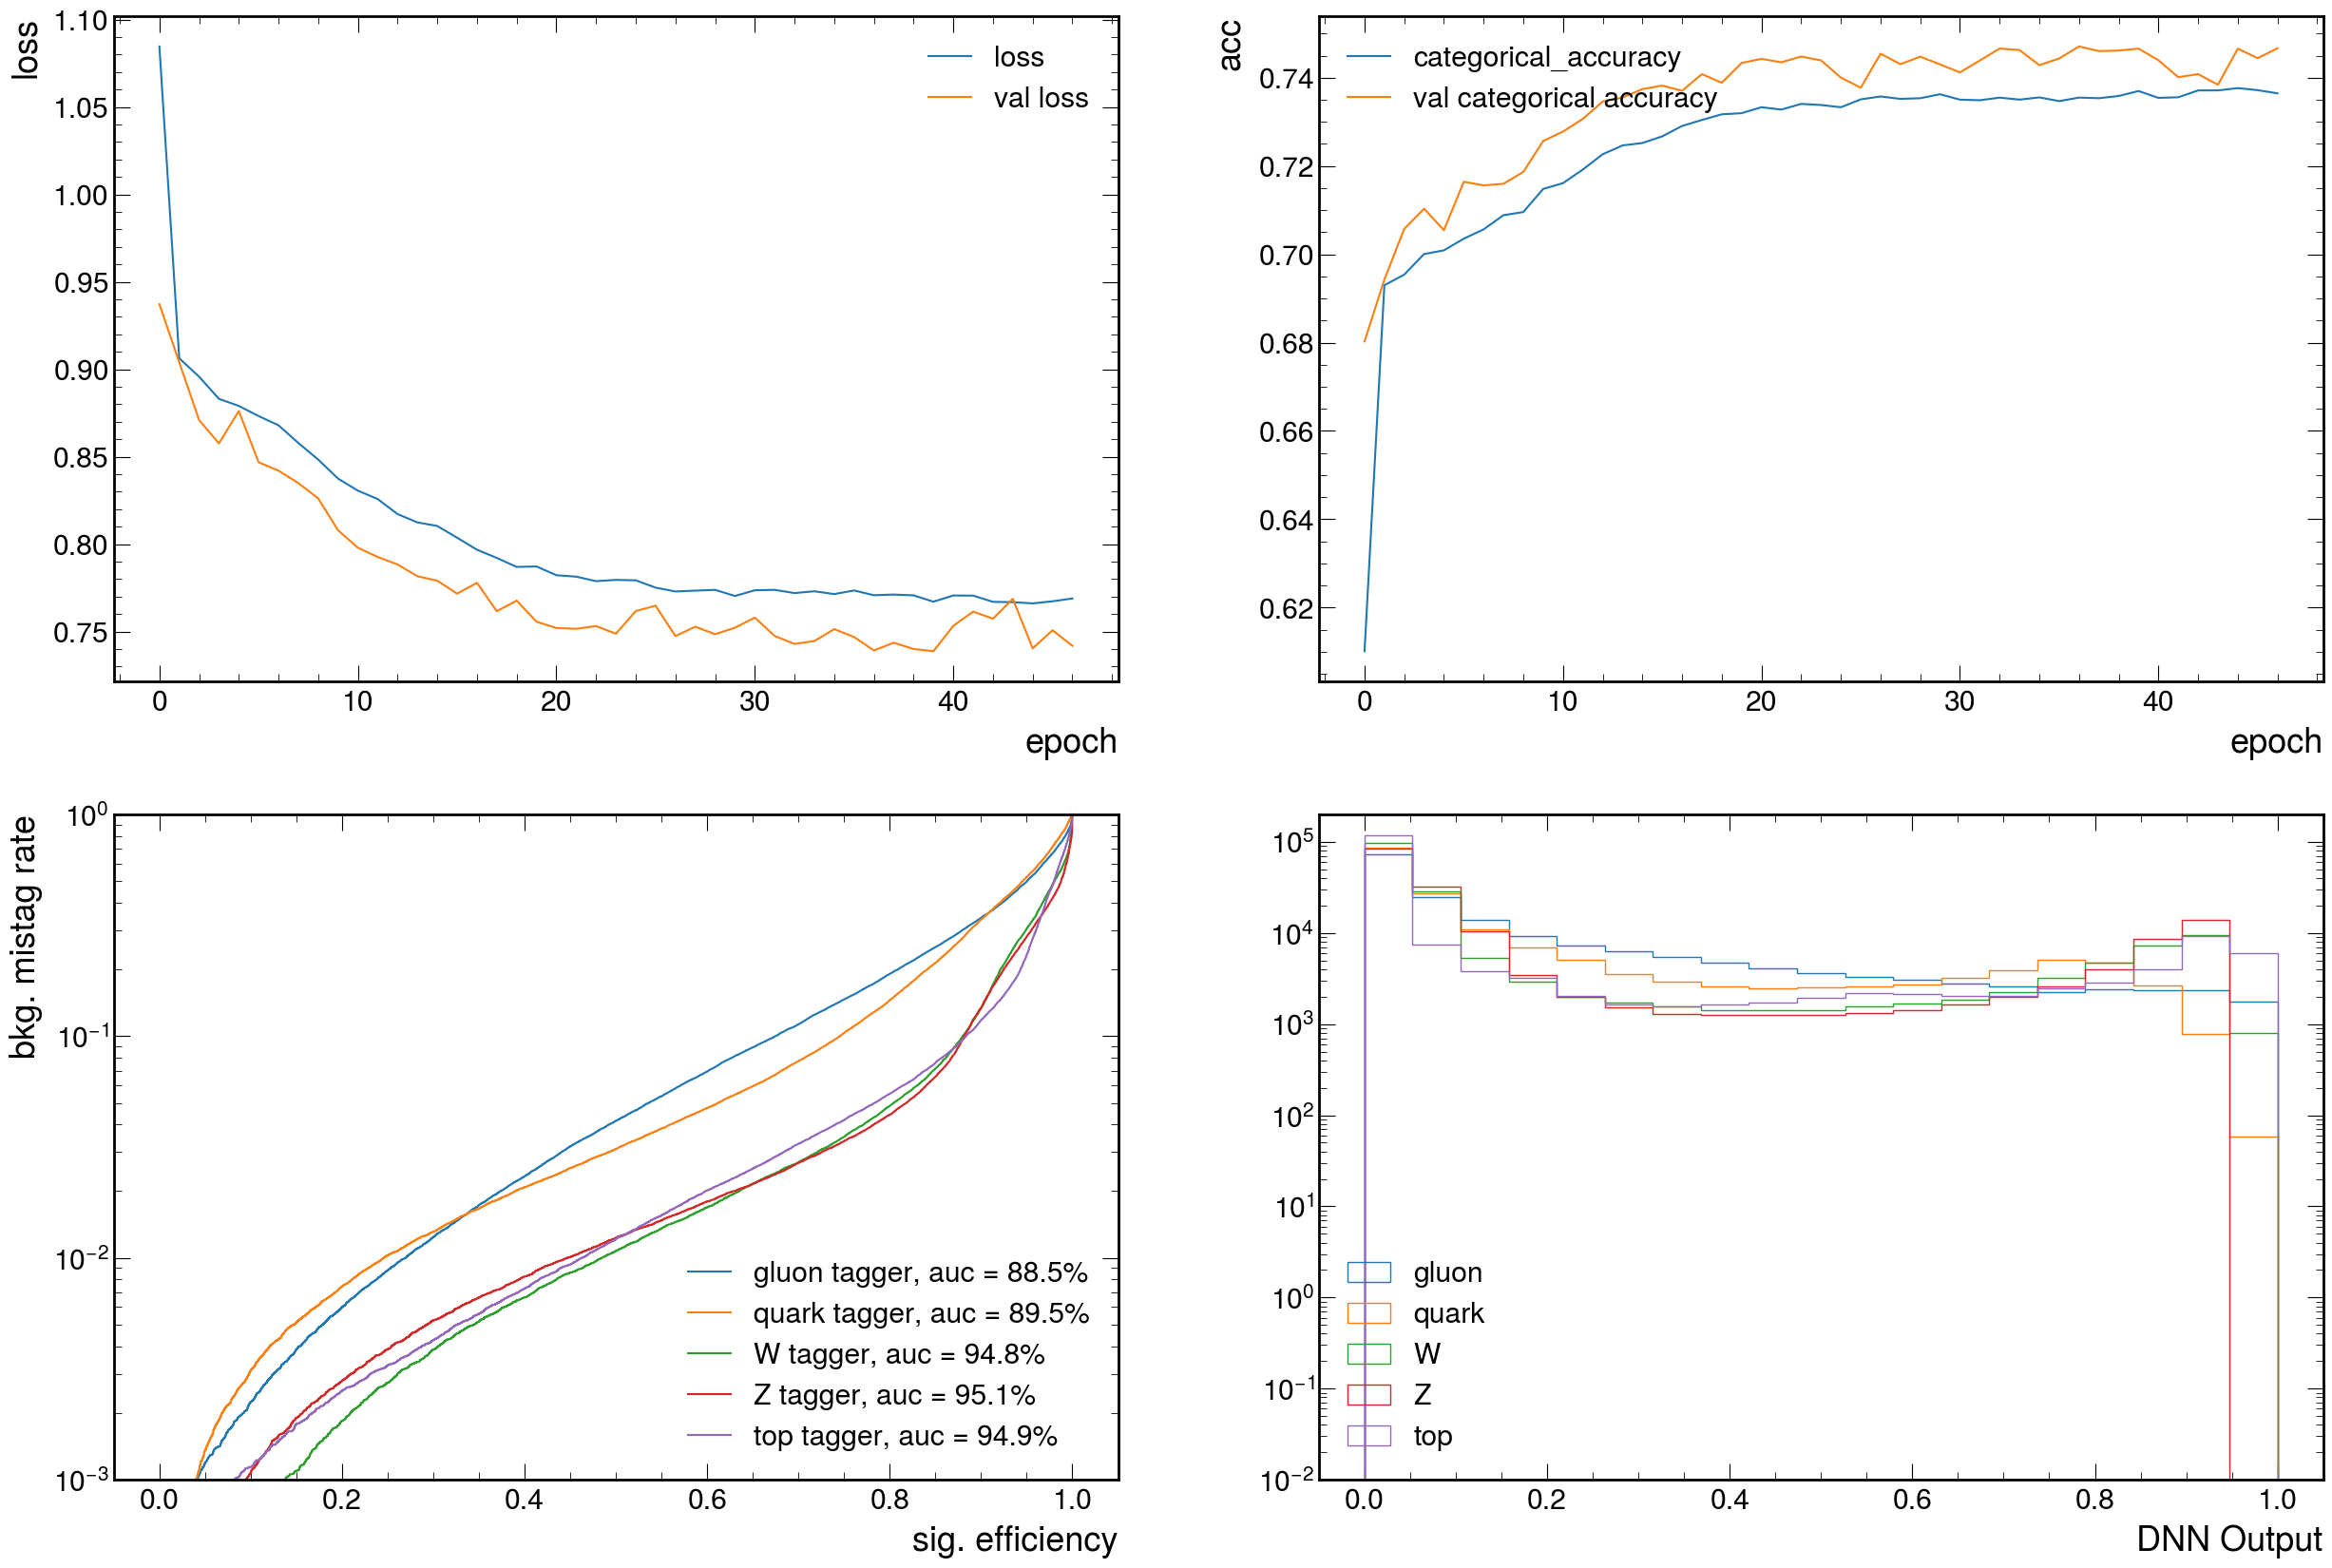

In [49]:
make_plots(model=model_zenodo,X_test=Zenodo_X_test,Y_test=Zenodo_Y_test,history=history_zenodo)

9075/9075 [==============================] - 18s 2ms/step
(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


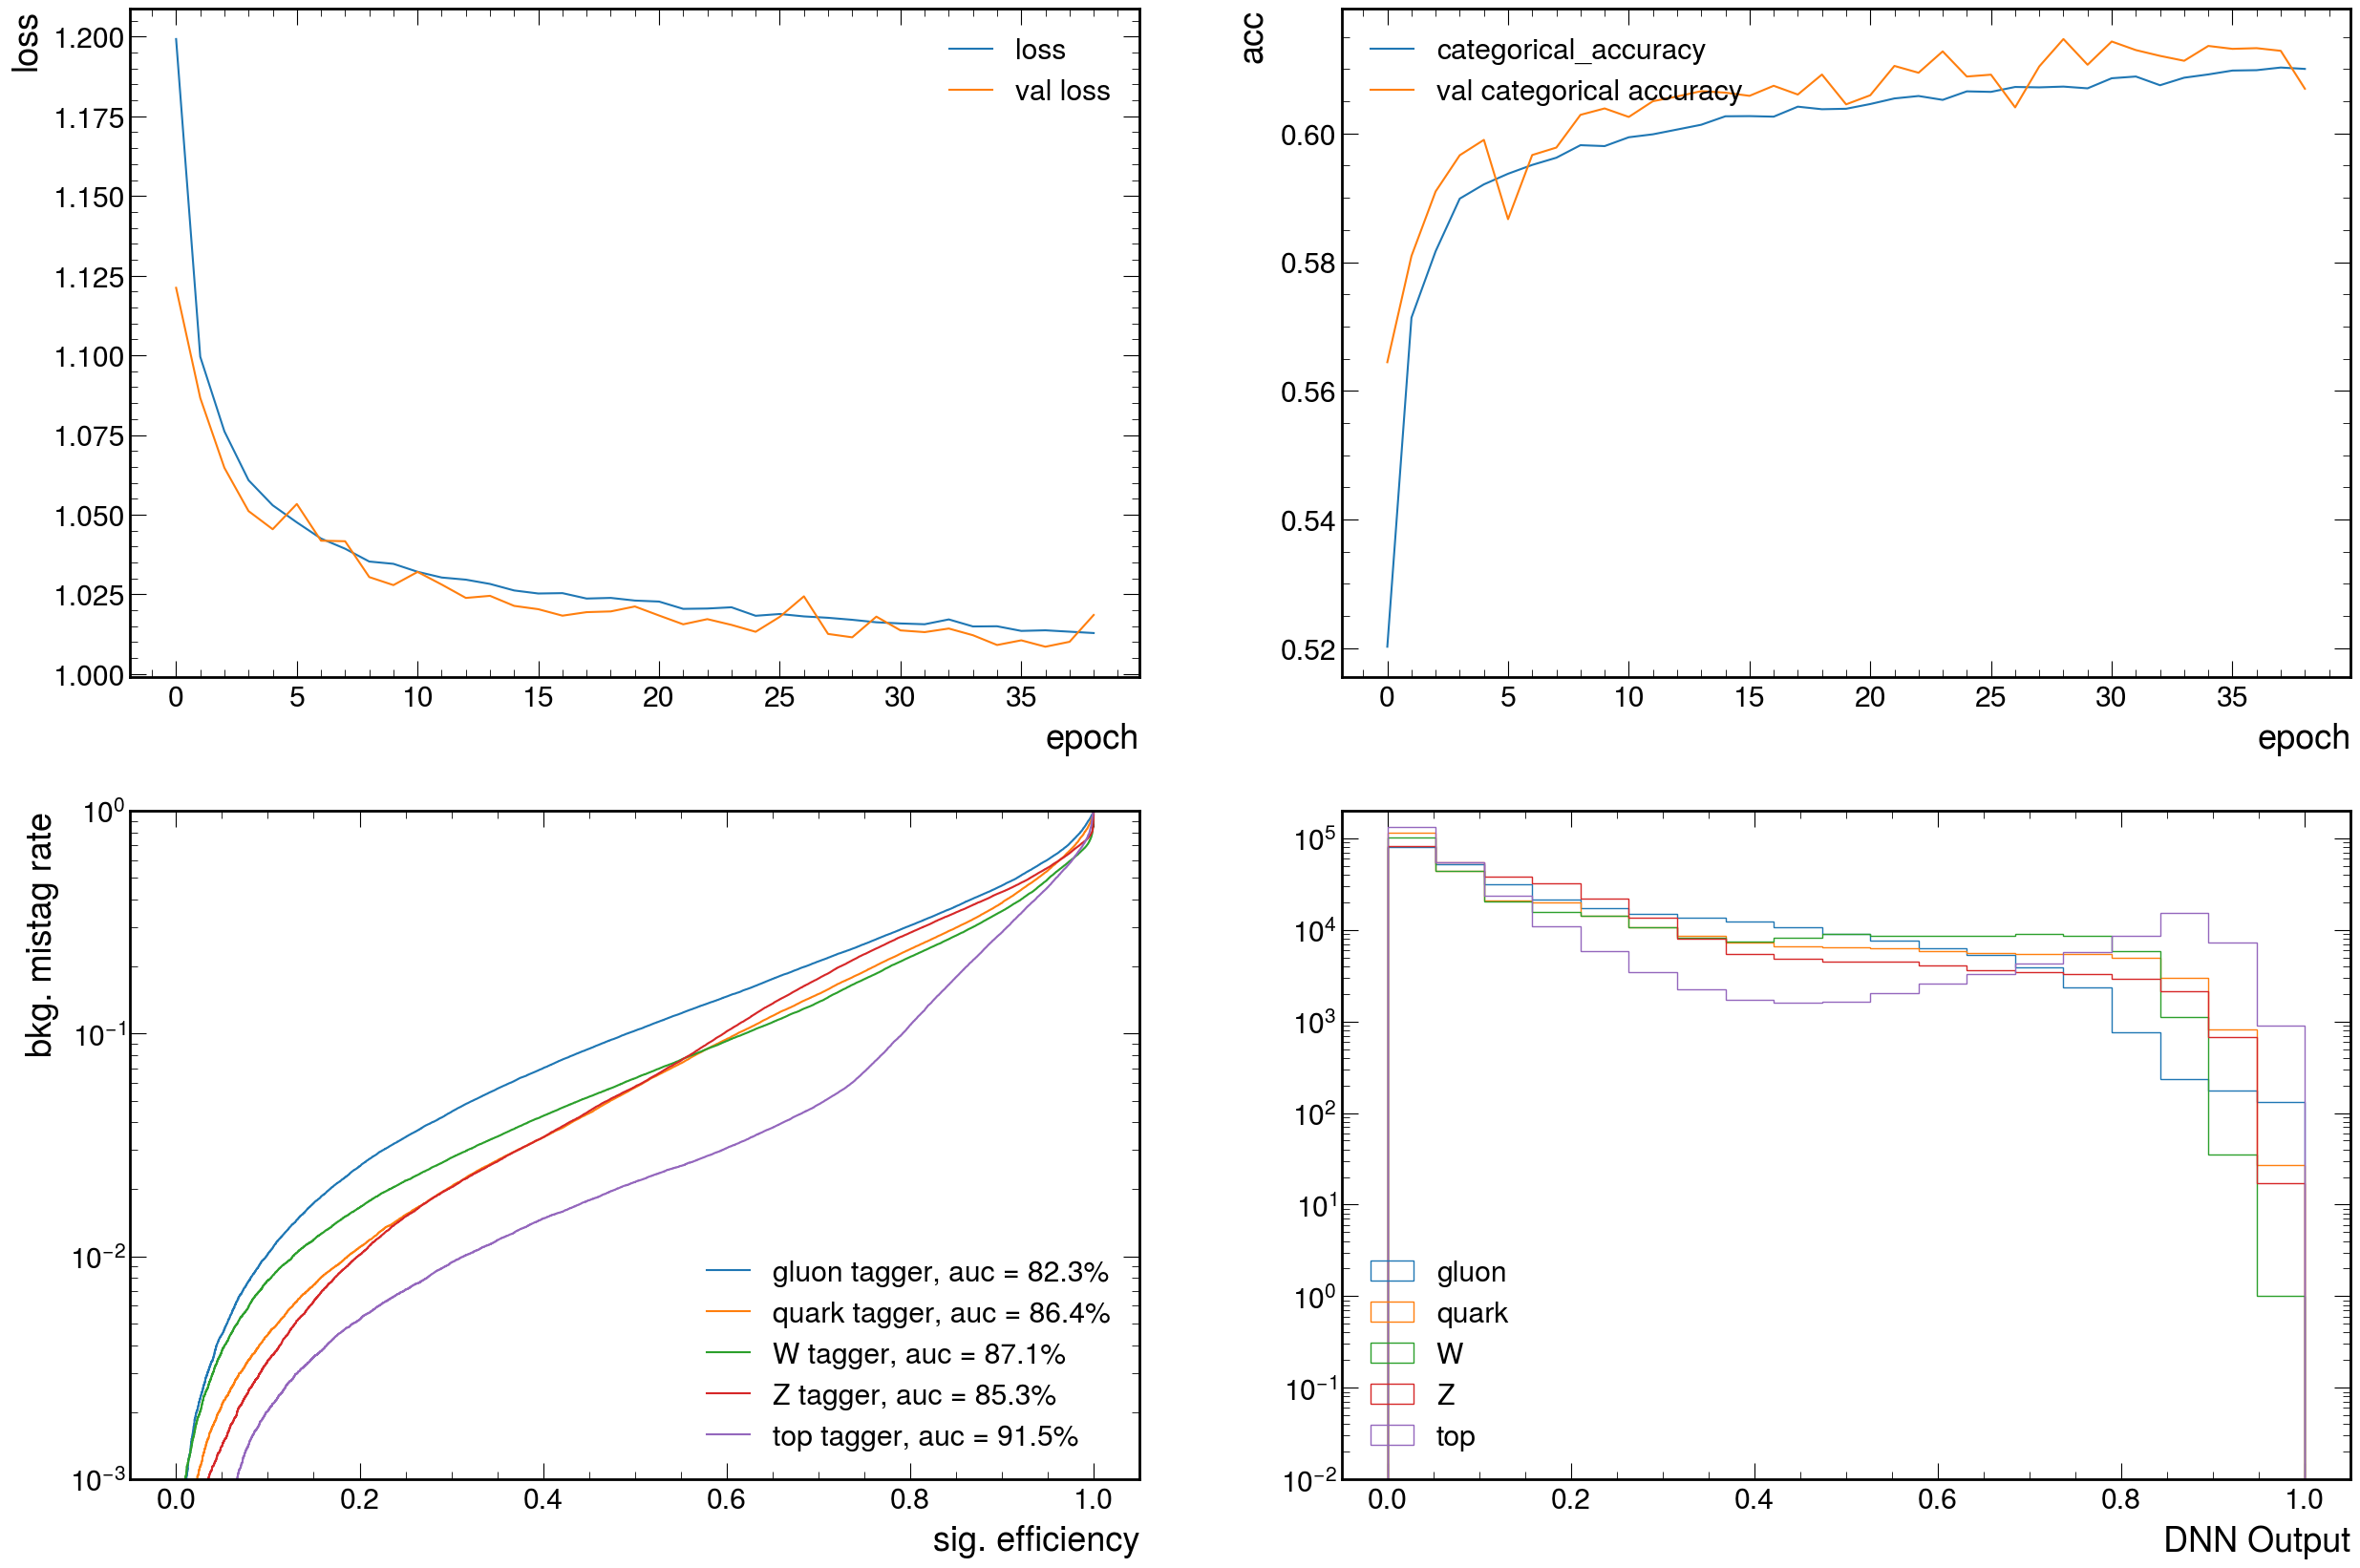

In [50]:
make_plots(model=model_andre,X_test=Andre_X_test,Y_test=Andre_Y_test,history=history_Andre)

347/347 [==============================] - 1s 2ms/step
(array([0., 1.]), array([10951,   131]))
(array([0., 1.]), array([10847,   235]))
(array([0., 1.]), array([  366, 10716]))


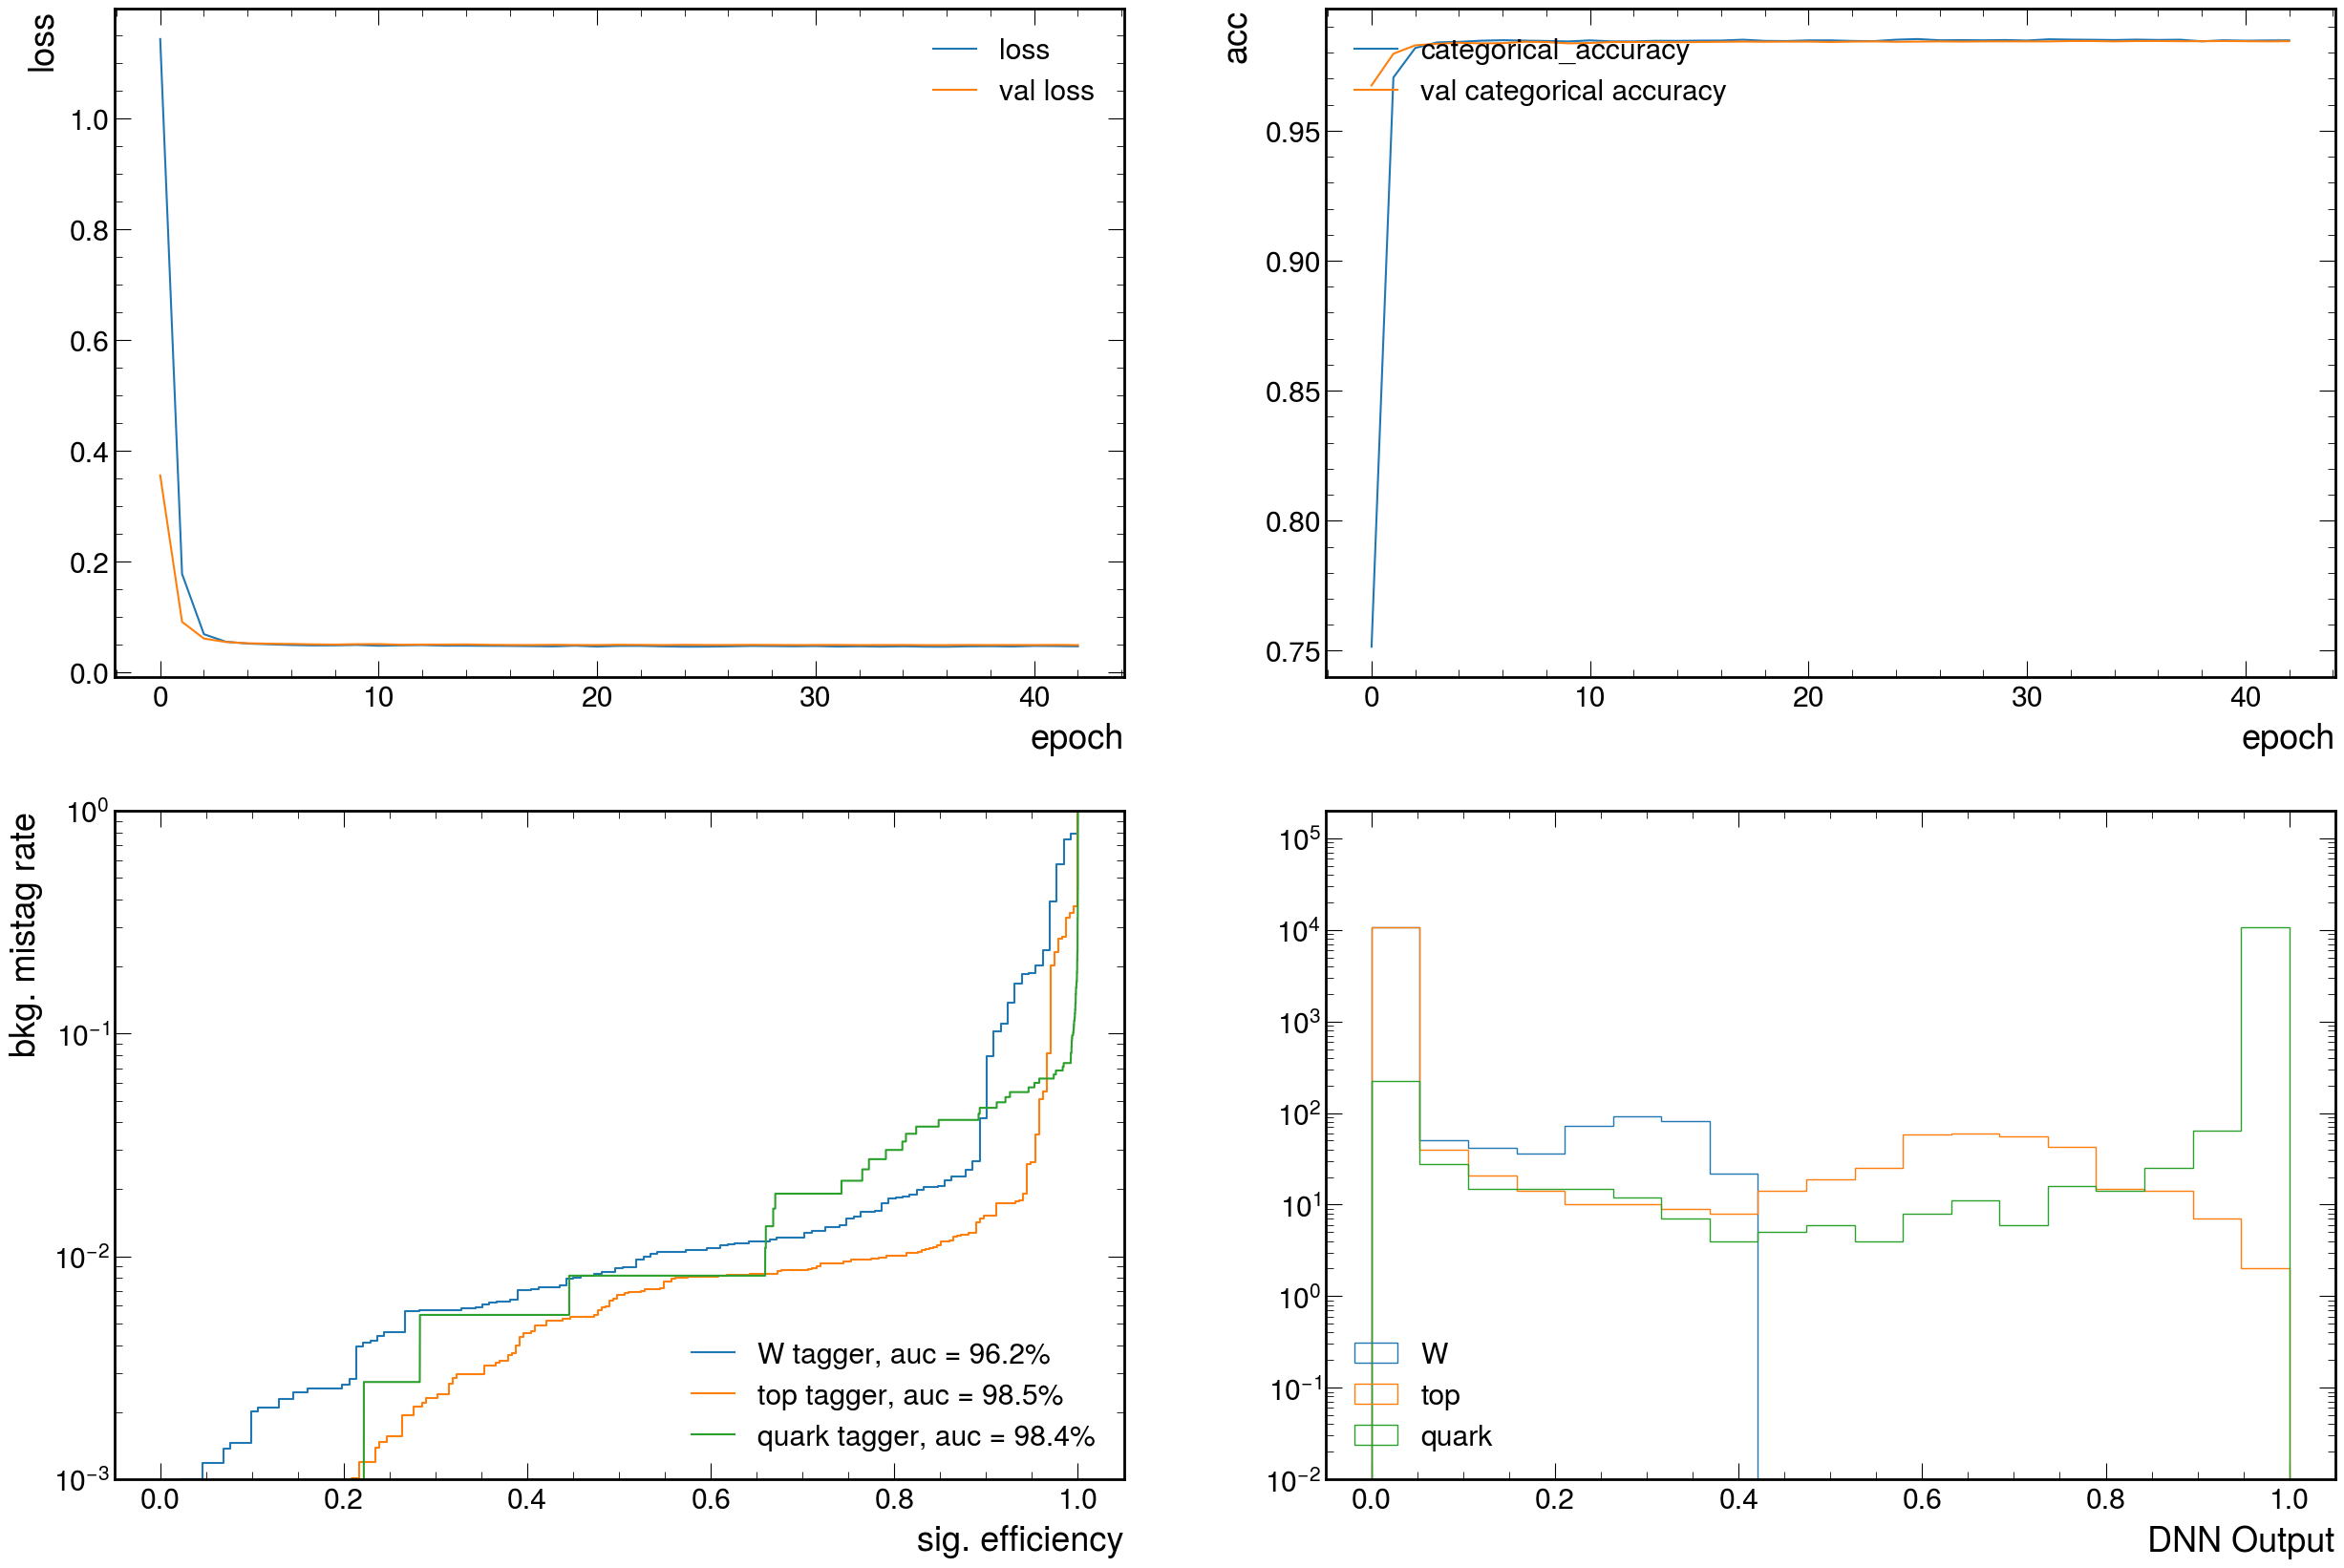

In [51]:
# Miguel_Y_test_8.shape
make_plots(model=model_miguel_8,X_test=Miguel_X_test_8,Y_test=Miguel_Y_test_8,history=history_Miguel_8,labels=['W','top','quark'])

347/347 [==============================] - 1s 3ms/step
(array([0., 1.]), array([10951,   131]))
(array([0., 1.]), array([10847,   235]))
(array([0., 1.]), array([  366, 10716]))


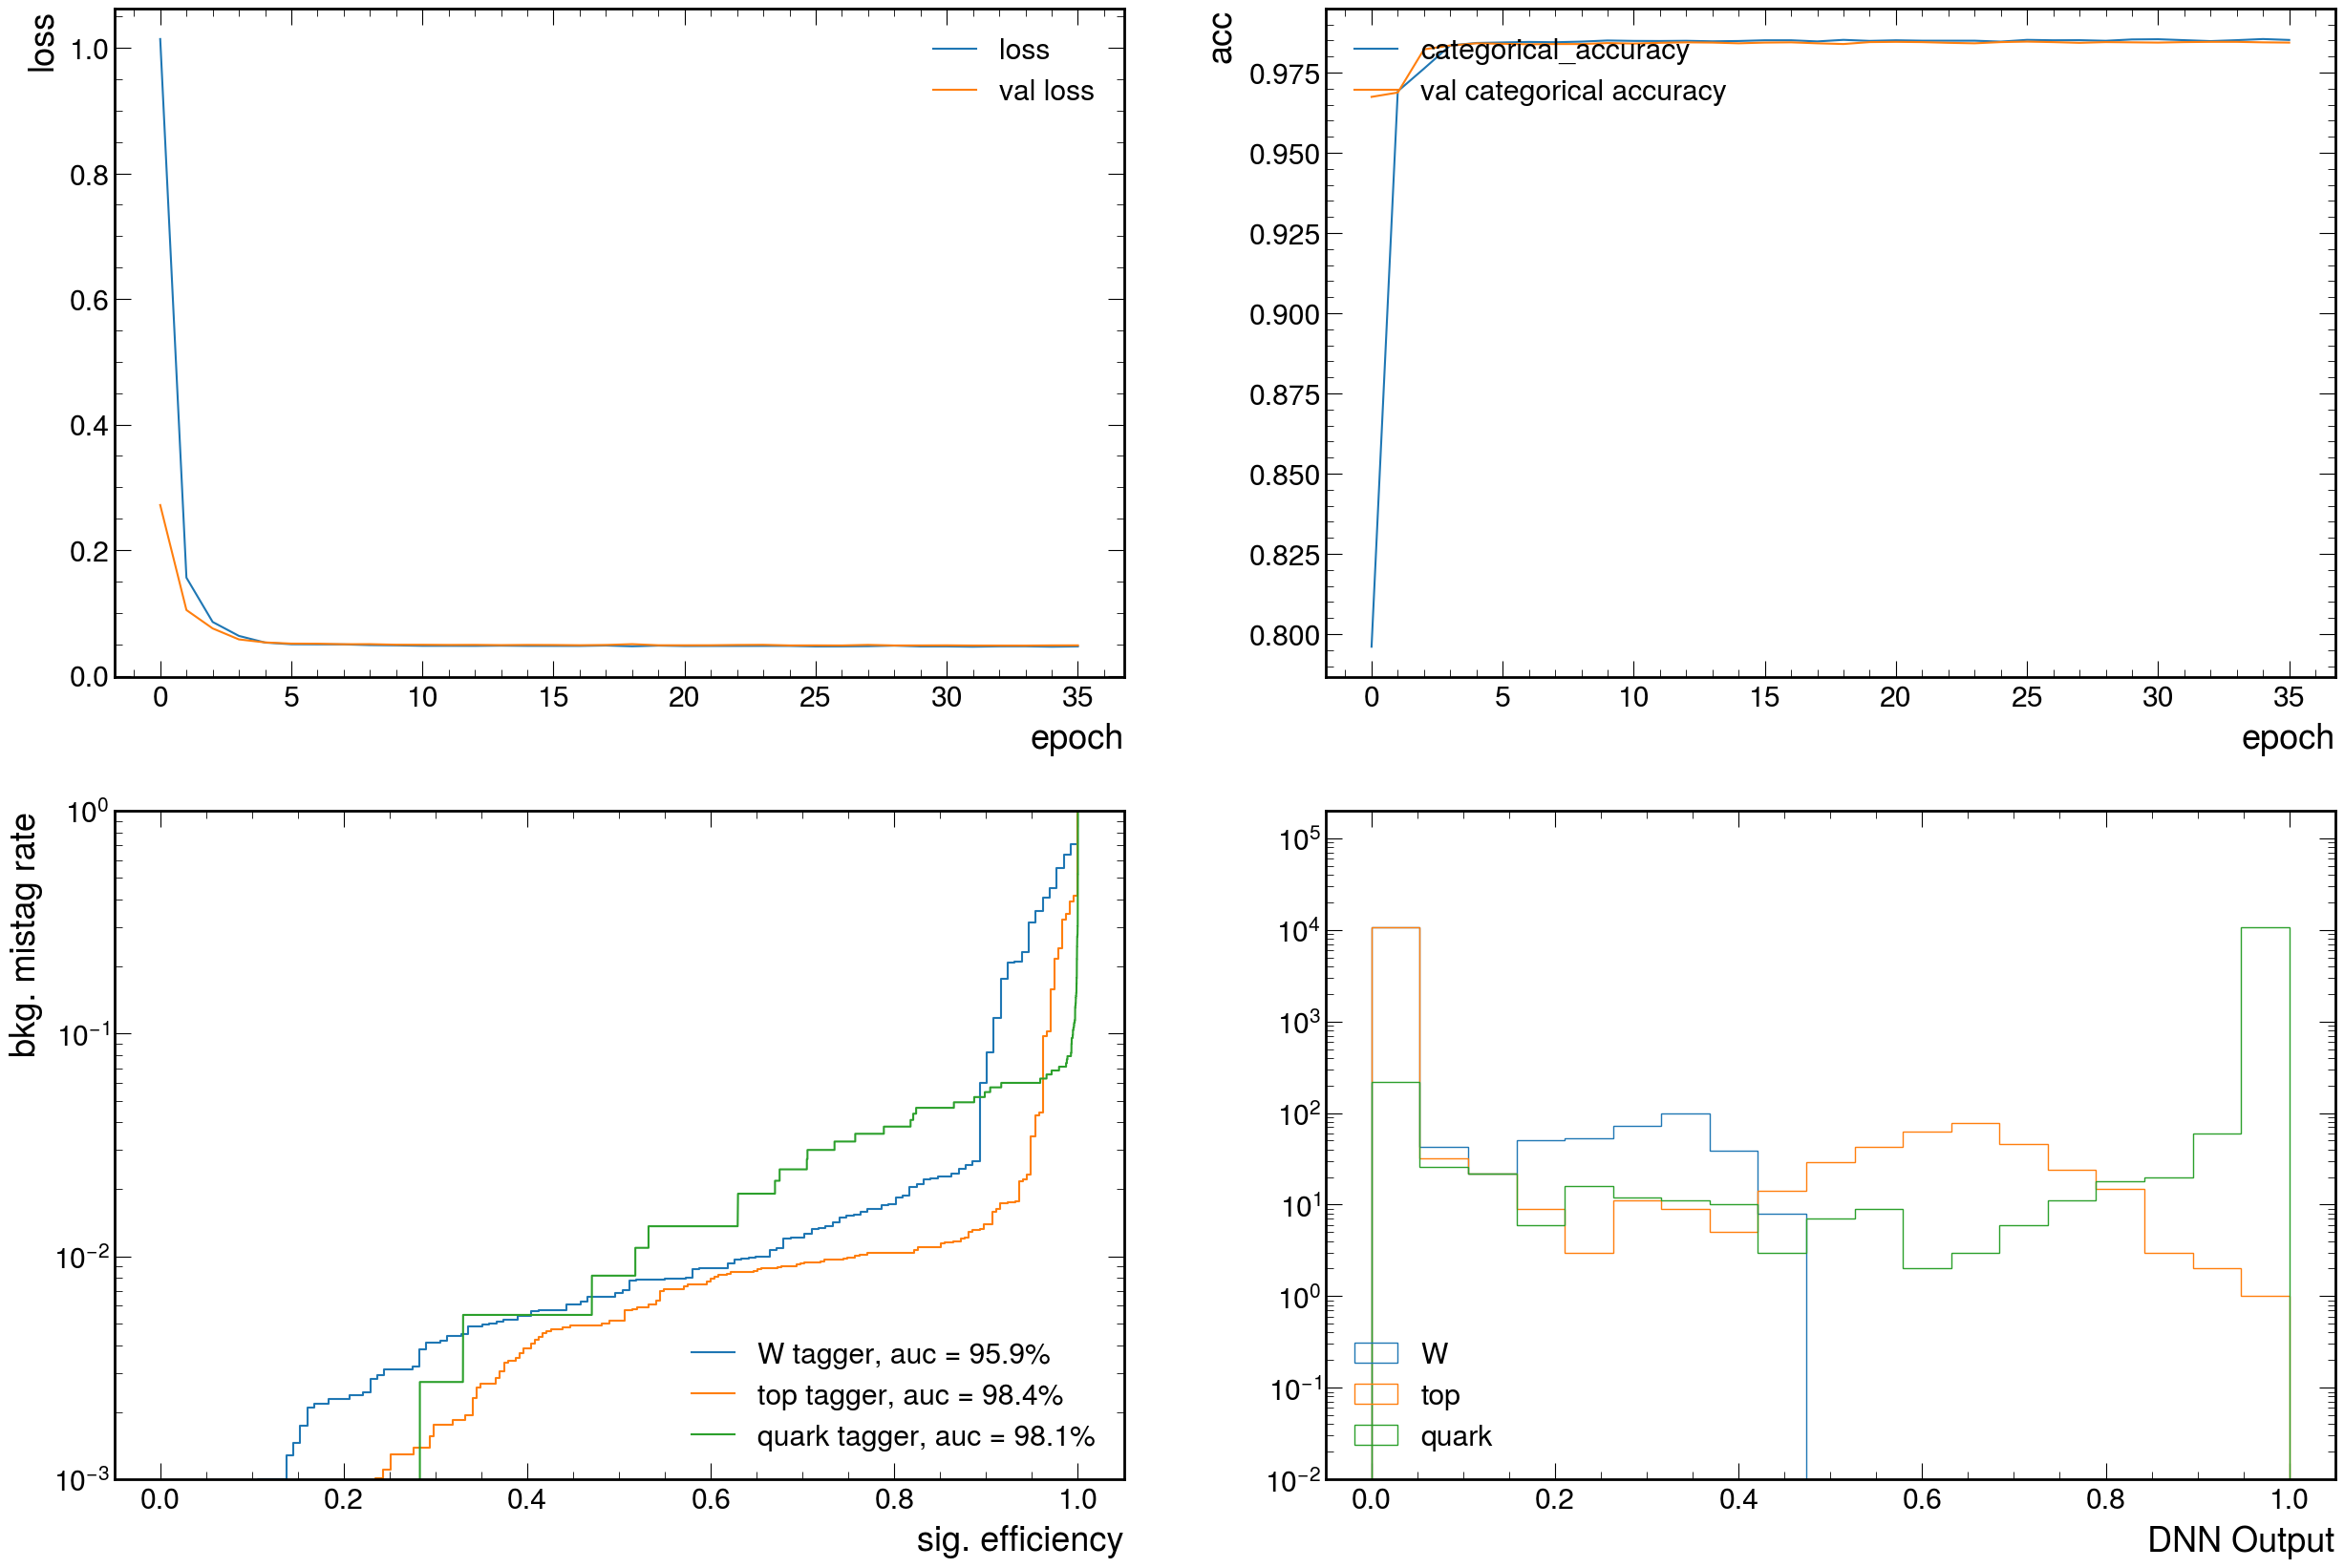

In [52]:
make_plots(model=model_miguel_16,X_test=Miguel_X_test_16,Y_test=Miguel_Y_test_16,history=history_Miguel_16,labels=['W','top','quark'])

347/347 [==============================] - 1s 2ms/step
(array([0., 1.]), array([10951,   131]))
(array([0., 1.]), array([10847,   235]))
(array([0., 1.]), array([  366, 10716]))


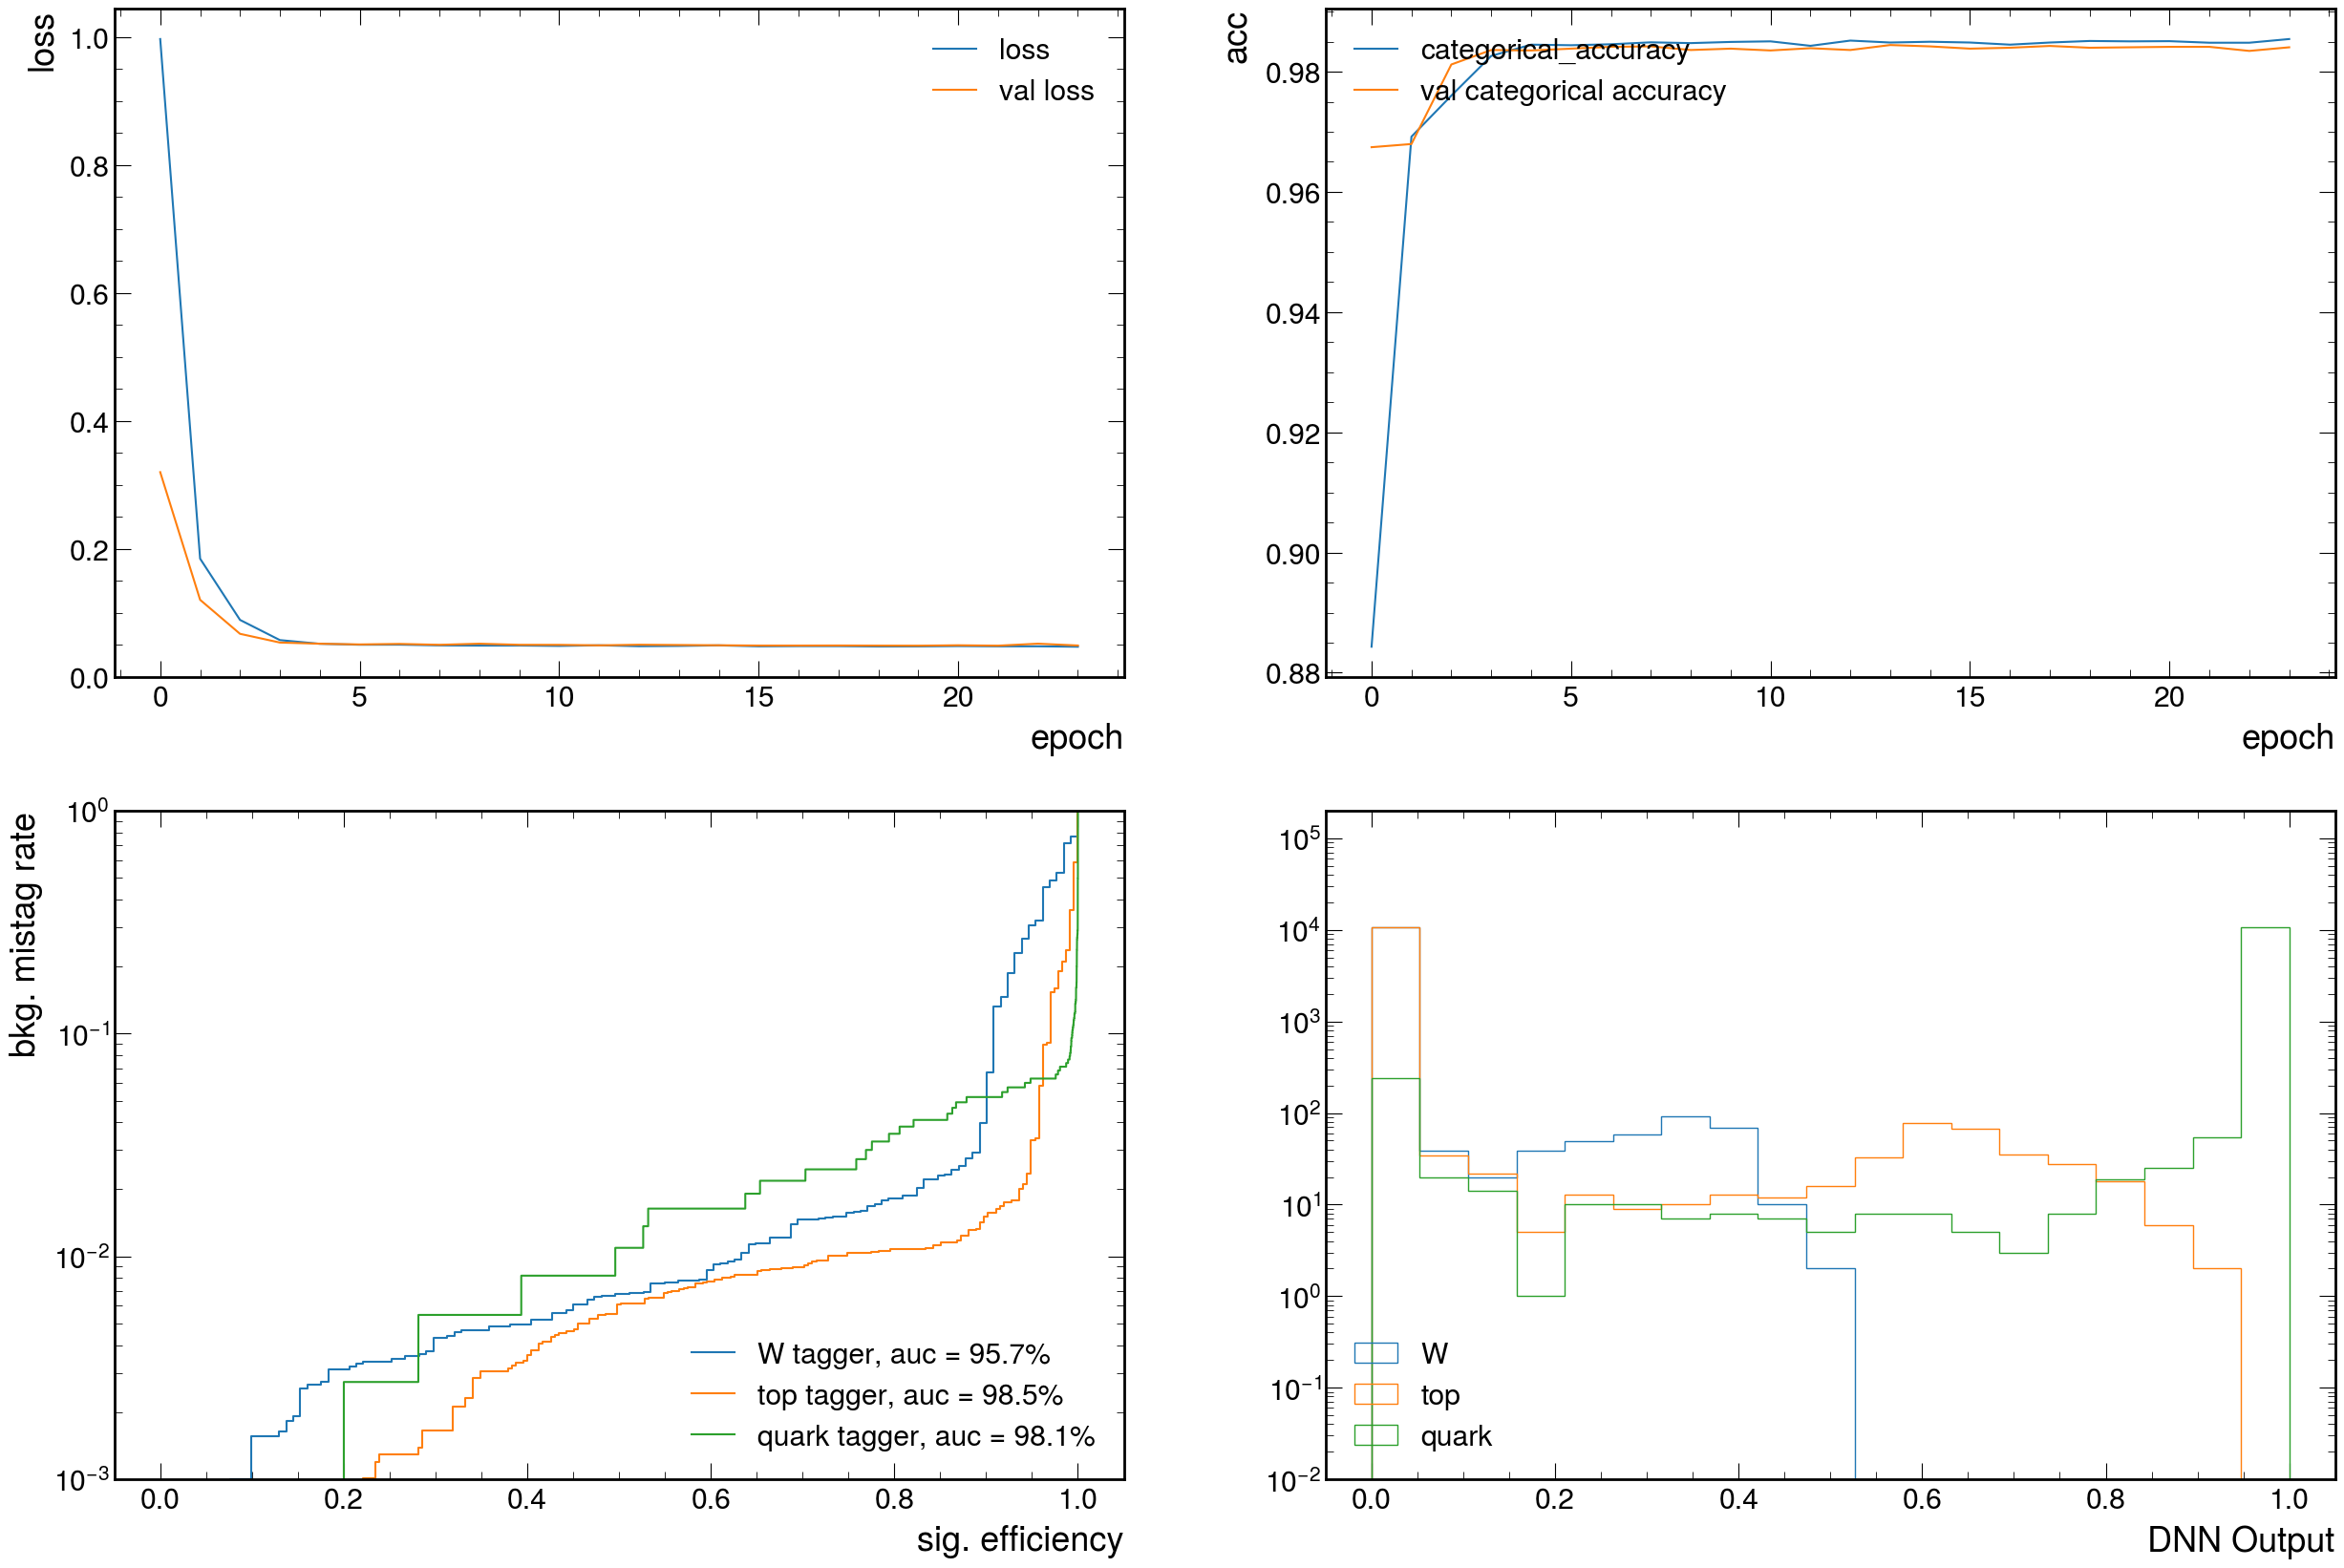

In [53]:
make_plots(model=model_miguel_30,X_test=Miguel_X_test_30,Y_test=Miguel_Y_test_30,history=history_Miguel_30,labels=['W','top','quark'])

In [67]:
def plot_DNN_output(model,X_test_qcd,X_test_w,X_test_t,name,tipo):
  labels = ['W','top','quark']
  # Plot loss vs epoch
  plt.figure(figsize=(12,8))
  ax = plt.subplot()
  # Estudo do W ao longo do Y
  X = np.linspace(0.0, 1.0, 20)
  Y_predict_w = model.predict(X_test_w)
  Y_predict_t = model.predict(X_test_t)
  Y_predict_qcd = model.predict(X_test_qcd)
  hist={}
  hist['Data W'] = ax.hist(Y_predict_w[:,tipo], bins=X, label='Data W' ,histtype='step')
  hist['Data Top'] = ax.hist(Y_predict_t[:,tipo], bins=X, label='Data Top' ,histtype='step')
  hist['Data QCD'] = ax.hist(Y_predict_qcd[:,tipo], bins=X, label='Data QCD' ,histtype='step')
  ax.semilogy()
  ax.set_xlabel('DNN Output of '+name)
  ax.legend(prop={'size': 5})
  ax.legend(loc='lower left')

  # Display plots
  fig = plt.gcf()
  plt.show()

1677/1677 [==============================] - 4s 3ms/step


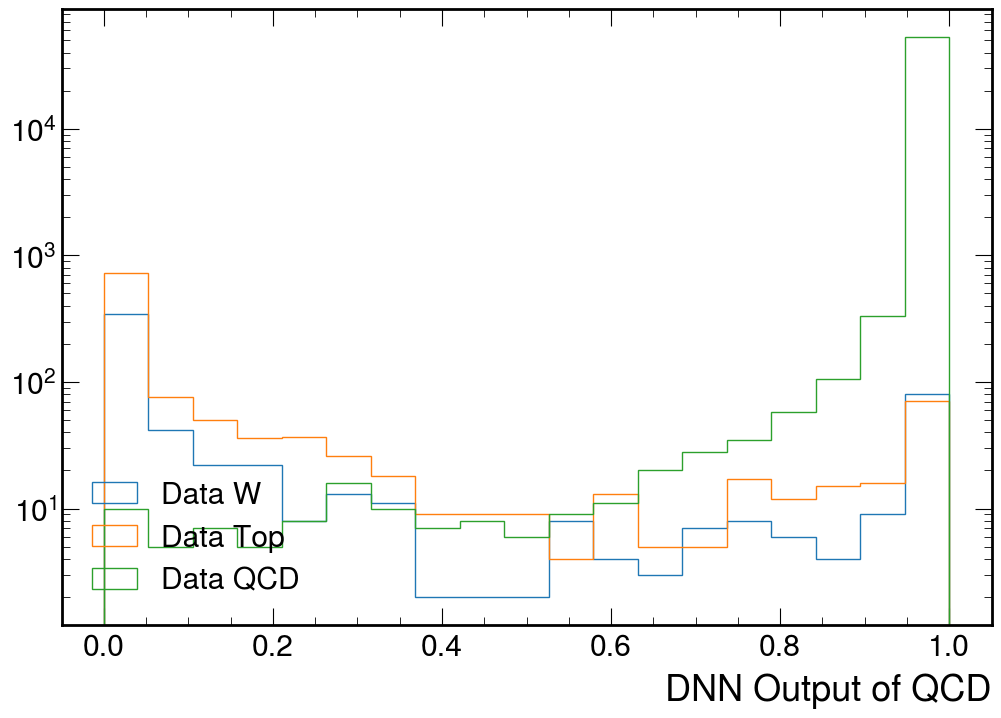

In [74]:
plot_DNN_output(model = model_miguel_8,X_test_qcd=Final_Miguel_X_qcd_8,X_test_w=Final_Miguel_X_w_8,X_test_t=Final_Miguel_X_t_8,name='QCD',tipo=1)

1677/1677 [==============================] - 4s 2ms/step


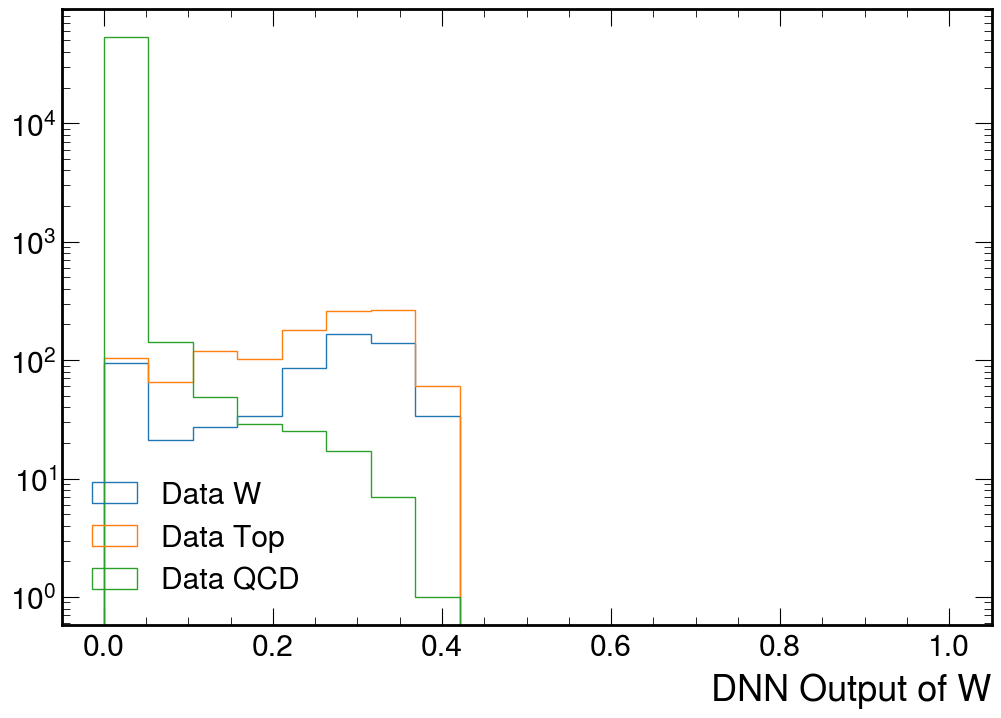

In [76]:
plot_DNN_output(model = model_miguel_8,X_test_qcd=Final_Miguel_X_qcd_8,X_test_w=Final_Miguel_X_w_8,X_test_t=Final_Miguel_X_t_8,name='W',tipo=2)

1677/1677 [==============================] - 3s 2ms/step


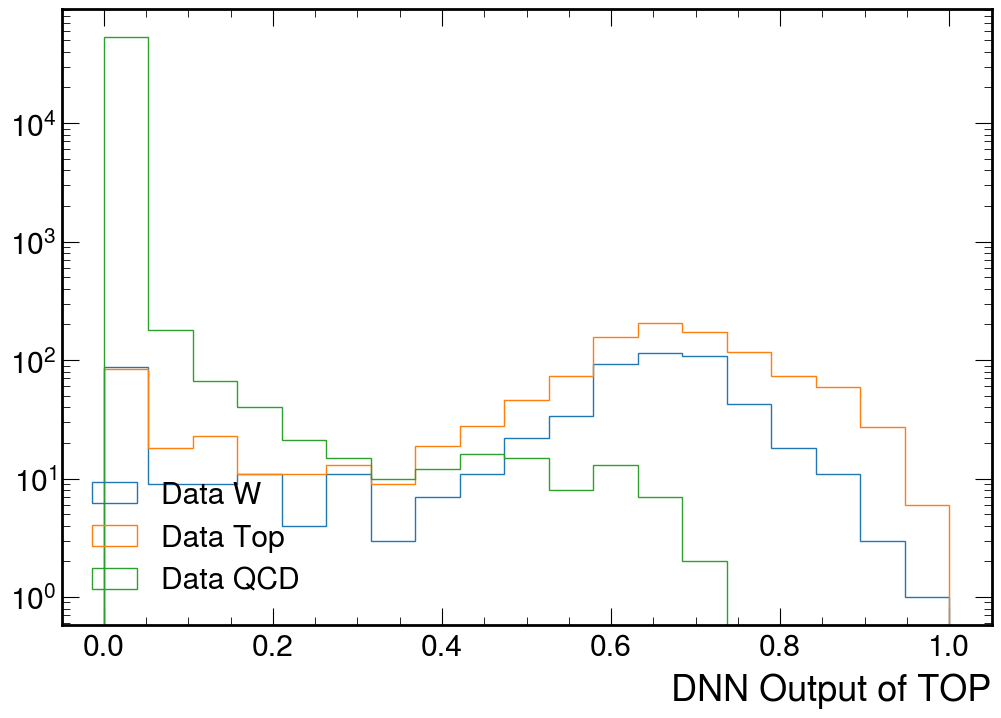

In [77]:
plot_DNN_output(model = model_miguel_8,X_test_qcd=Final_Miguel_X_qcd_8,X_test_w=Final_Miguel_X_w_8,X_test_t=Final_Miguel_X_t_8,name='TOP',tipo=4)

In [ ]:
# from sklearn.metrics import accuracy_score

# # Save plots
# fig.savefig(fname+'.pdf')


# # Save FPR for a given TPR value ( 30% , 50% & 80%)
# with open('FPR@TPR_'+fname+'.csv', 'w') as file:
#   file.write("model,label,treshold,tpr,fpr\n")
#   for label in labels:
#     for t in [0.3, 0.5, 0.8]:
#       index = np.argmax(tpr[label]>t)
#       file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
#       print("Label = ", label , " with treshold = ",t)
#       print("TPR = ",tpr[label][index])
#       print("FPR = ",fpr[label][index])
#       print(" ")


# # Save ROC AUC for each label
# with open('ROCAUC_'+fname+'.csv', 'w') as file:
#   header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
#   file.write(header)
#   rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
#   file.write(rocauc)



# # Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
# acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
# with open('ACCURACY_'+fname+'.csv', 'w') as file:
#   header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
#   file.write(header)
#   accuracy = ''
#   for label in labels:
#     idx = np.argmax( tresholds[label] <= 0.5 )
#     accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
#   accuracy += str(acc_avg)
#   file.write(accuracy)


# '''
# # Save confusion matrix ndarrays to .npz file
# with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
#     vars = {}
#     vars[arch]=np.array(1) # save model name
#     for label in labels:
#         vars['tresholds_'+label+'_'+arch] = tresholds[label]
#         vars['TP_'+label+'_'+arch] = TP[label]
#         vars['FP_'+label+'_'+arch] = FP[label]
#         vars['TN_'+label+'_'+arch] = TN[label]
#         vars['FN_'+label+'_'+arch] = FN[label]
#         vars['TPR_'+arch] = tpr[label]
#         vars['FPR_'+arch] = fpr[label]
#         vars['NP_'+arch]= NP[label]
#         vars['NN_'+arch]= NN[label]
#         vars['auc_'+arch] = auc1[label]
# #        print(vars)
#     np.savez(file, **vars)
# '''

# '''
# # Save a sample of events for HLS
# njets=3000
# print(X_test.shape)
# np.save('x_test.npy', X_test[0:njets,:])
# np.save('y_test.npy', Y_test[0:njets,:])
# '''